# Introduction

L'objectif de ce notebook est d'analyser les sentiments des internautes envers ChatGPT. Les données sont tirées d'une base de données de 500k tweets, provenant de Kaggle.

## Étapes
- Installation des outils - libraires spécialisées de R
- Importation des données
- Comprendre le jeu de données
- Traitement préliminaires des données
- Analyse des données
    * Analyse de la polarité
    * Analyse du contenu des tweets
    * Analyse des sentiments avec le lexique Bing
    * Analyse des émotions avec le modèle de Plutchik
    * Analyses de l'évolution de la polarité
    * Analyses de l'évolution des sentiments


# Installation des outils - libraires spécialisées de R

In [ ]:
# installation des librairies spécialisées de R
install.packages("rJava")
install.packages("qdap")
install.packages("tidytext")
install.packages("dplyr")
install.packages("ggplot2")
install.packages("stopwords")

In [ ]:
# si la librairie qdap ne se charge pas, vous pouvez installer les outils 
# de développement et la librairie dans le paquet trinker
install.packages("devtools")
install_github("trinker/qdapDictionaries")
install_github("trinker/qdapRegex")
install_github("trinker/qdapTools")
install_github("trinker/qdap")

In [1]:
# activation des librairies 
library(devtools)
library(rJava)
library(qdap)
library(ggplot2)
library(tidytext)
library(dplyr)
library(wordcloud)
library(stopwords)

Loading required package: usethis

Loading required package: qdapDictionaries

Loading required package: qdapRegex

Loading required package: qdapTools

Loading required package: RColorBrewer


Attaching package: 'qdap'


The following objects are masked from 'package:base':

    Filter, proportions



Attaching package: 'ggplot2'


The following object is masked from 'package:qdapRegex':

    %+%



Attaching package: 'dplyr'


The following object is masked from 'package:qdapTools':

    id


The following object is masked from 'package:qdapRegex':

    explain


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# réglages des options
# affichage des graphiques plus larges (Jupyter Notebook)
options(repr.plot.width=16, repr.plot.height=9)

In [3]:
# Fonction Multiple plot
# tiré de http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Importation des données

In [4]:
# importation du fichier csv contenant les données
# le fichier est importé de répertoire public Kaggle :
# https://www.kaggle.com
# /datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023
tweetsFile <- read.csv("Twitter Jan Mar.csv", header=TRUE)

# Comprendre le jeu de données

In [5]:
# on examine les 10 premières lignes du dataframe pour se faire une idée
head(tweetsFile)

,date,id,content,username,like_count,retweet_count
,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb #ChatGPT",RealProfitPros,0,0
2,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it<80><99>s 15. <9f><98><82>,AmyLouWho321,0,0
3,2023-03-29 22:57:53+00:00,1641213115684536323,"https://t.co/FjJSprt0te - Chat with any PDF! Check out how this new AI quickly answers questions from your PDFs. Perfect for students, researchers, and other curious minds. #research #chatpdf #ChatGPT",yjleon1976,0,0
4,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all face the judge of destiny and the jury of our actions. <9a><96><8f><9f><94> #OutOfContextAI #AILifeLessons #ChatGPT",ChatGPT_Thinks,0,0
5,2023-03-29 22:57:26+00:00,1641213003260633088,"Most people haven't heard of Chat GPT yet. First, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines",nikocosmonaut,0,0
6,2023-03-29 22:57:20+00:00,1641212975012016128,@nytimes No! Chat Gpt has been putting together amazing recipes <9f><98><9f><98><9f><98>,cordydbarb,0,0


In [6]:
# dimensions du dataframe pour voir le nombre le lignes et de colonnes
dim(tweetsFile)

[1] 500036      6

In [24]:
# informations de base du dataframe
# chaque ligne contient les informations d'un tweet
# date : 
#  contient la date et l'heure du tweet
#  variable de type string (chaîne de caractères)
# id : 
#  numéro d'identification du tweet
#  variable de type string (chaîne de caractères)
# content : 
#  contenu du tweet
# variable de type string (chaîne de caractères)
# username : 
#  nom d'utilisateur sur Twitter ayant fait le tweet
#  variable de type string (chaîne de caractères)
# like_count :
#  nombre de mention J'aime du tweet
#  variable de type int (nombre entier)
# retweet_count : 
#  nombre de fois où le tweet a été repartagé
#  variable de type int (nombre entier)
str(tweetsFile)

'data.frame':	500036 obs. of  6 variables:
 $ date         : chr  "2023-03-29 22:58:21+00:00" "2023-03-29 22:58:18+00:00" "2023-03-29 22:57:53+00:00" "2023-03-29 22:57:52+00:00" ...
 $ id           : chr  "1641213230730051584" "1641213218520481805" "1641213115684536323" "1641213110915571715" ...
 $ content      : chr  "Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb   #ChatGPT" "@MecoleHardman4 Chat GPT says it\342\200\231s 15. \360\237\230\202" "https://t.co/FjJSprt0te - Chat with any PDF!\nCheck out how this new AI quickly answers questions from your PDF"| __truncated__ "AI muses: \"In the court of life, we must all face the judge of destiny and the jury of our actions. \342\232\2"| __truncated__ ...
 $ username     : chr  "RealProfitPros" "AmyLouWho321" "yjleon1976" "ChatGPT_Thinks" ...
 $ like_count   : int  0 0 0 0 0 0 1 0 0 2 ...
 $ retweet_count: int  0 0 0 0 0 0 0 0 0 0 ...


In [9]:
# Statistiques de base (quartiles) sur les likes (mention J'aime)
# certains tweets ont eu jusqu'à 64094 likes!
summary(tweetsFile$like_count)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    0.00     0.00     1.00     7.12     2.00 64094.00       62 

In [10]:
# Statistiques de base (quartiles) sur les retweets (repartage)
# la très grand majorité ont eu 0 retweets
summary(tweetsFile$retweet_count)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
    0.000     0.000     0.000     1.482     0.000 16080.000        62 

In [13]:
# le top 10 des tweets en termes de likes
top_n(tweetsFile, 10, like_count) %>%
    arrange(desc(like_count)) %>%
    select(c(date, username, content, like_count))
    

date,username,content,like_count
<chr>,<chr>,<chr>,<int>
2023-02-03 23:09:47+00:00,MoistCr1TiKaL,Writing erotic prompts for Chat GPT hoping to be the first person to make AI cum. It<80><99>s like the Turing Test,64094
2023-01-13 04:30:44+00:00,johnvianny,Best AI Tools You Need To Know #chatgpt #chatgpt3 #ArtificialIntelligence #ai https://t.co/0jfr8cOMoo,63835
2023-03-06 00:28:40+00:00,rgay,"I am pretty sure I am reading my first CHAT GPT student essay and like, teachers, don't panic. You'll know it when you see it.",44940
2023-01-07 04:31:47+00:00,aaronsiim,ultra-modern generative ai<9f><97><8f>: <80> AI2 <80> AI21 <80> mdm <80> gpt-J <80> gpt-3 <80> x-clip <80> bloom <80> cohere <80> gopher <80> dall<80>e 2 <80> craiyon <80> tabnine <80> jukebox <80> chatGPT *** <80> anthropic <80> codegeex <80> nvidia get3d <80> dreamfusion <80> stable diffusion <80> meta make-a-video https://t.co/ON5eIGvnEQ,42125
2023-01-12 08:04:15+00:00,kevinschawinski,First #ChatGPT answer which made me pause. https://t.co/nbc9uRoWlA,38278
2023-01-18 13:49:14+00:00,writingtoriches,AI copywriting tools to check out: 1. Chat GPT - Research 2. QuillBot - Paraphrasing 3. StoryLab - Hooks and outlines 4. Grammarly - Grammar/spelling 5. Hemingway - Conciseness/clarity 6. Power Thesaurus - Thesaurus 7. Tweet Hunter - Content creation What else?,37048
2023-03-29 11:23:49+00:00,ProudFede,Chat GPT reveals <80><9c>The Best 11 Of All Time<80><9d> https://t.co/NJp7KJfjp3,28049
2023-03-14 17:02:28+00:00,sama,"here is GPT-4, our most capable and aligned model yet. it is available today in our API (with a waitlist) and in ChatGPT+. https://t.co/2ZFC36xqAJ it is still flawed, still limited, and it still seems more impressive on first use than it does after you spend more time with it.",22310
2023-01-10 20:44:23+00:00,AlexHormozi,"This is a frightening visual for me. The first dot is the amount of data Chat GPT 3 was trained on. The second is what chat GPT 4 is trained on. They are already doing demos. It can write a 60,000 word book from a single prompt. The only question I've had about AI<80> https://t.co/DnAEMm60lh",21476


In [14]:
# le top 10 des tweets en termes de retweet
top_n(tweetsFile, 10, retweet_count) %>% 
    arrange(desc(retweet_count)) %>%
    select(c(date, username, content, retweet_count))

date,username,content,retweet_count
<chr>,<chr>,<chr>,<int>
2023-01-13 04:30:44+00:00,johnvianny,Best AI Tools You Need To Know #chatgpt #chatgpt3 #ArtificialIntelligence #ai https://t.co/0jfr8cOMoo,16080
2023-01-07 04:31:47+00:00,aaronsiim,ultra-modern generative ai<9f><97><8f>: <80> AI2 <80> AI21 <80> mdm <80> gpt-J <80> gpt-3 <80> x-clip <80> bloom <80> cohere <80> gopher <80> dall<80>e 2 <80> craiyon <80> tabnine <80> jukebox <80> chatGPT *** <80> anthropic <80> codegeex <80> nvidia get3d <80> dreamfusion <80> stable diffusion <80> meta make-a-video https://t.co/ON5eIGvnEQ,11501
2023-01-18 13:49:14+00:00,writingtoriches,AI copywriting tools to check out: 1. Chat GPT - Research 2. QuillBot - Paraphrasing 3. StoryLab - Hooks and outlines 4. Grammarly - Grammar/spelling 5. Hemingway - Conciseness/clarity 6. Power Thesaurus - Thesaurus 7. Tweet Hunter - Content creation What else?,10498
2023-01-09 04:35:00+00:00,garryflix,"Creators and writers are making $1,000,000s using ChatGPT. But 99% of people don't know how to build a Business and make money using it. I just built ChatGPT Business Crash Course. Free for the next 24 hours! Like, RT &amp; comment ""GPT"" and I'll DM it to you (Must be following) https://t.co/L3qVoUudOk",8096
2023-03-25 04:31:39+00:00,crypto_bearr,$150 || 7250 PHP || 2.1 IDR $100 <9c><85> RT &amp; Follow @gptaiinu +$50 <9c><85> Join Telegram (post proof) https://t.co/sUAaxEo8D0 ends in 48 hours ------------ First ChatGPT lead Crypto Project. <9f><96><9f><9a><80> DEX- https://t.co/CzcEyt8xy8 #ChatGPT https://t.co/rH00LZM3oK,8060
2023-02-24 13:49:22+00:00,TheRavenCrypto,$250 <80><94> 48 Hours <80><94> <9e><96> RT &amp; Follow: @DegenAI2 <9e><96>Join Telegram: https://t.co/WyPzGgbdBE <9e><96> Generate an image using our telegram bot and post in on a tweet with the tags (TAGS) @DegenAI2 #altcoins #altcoin #DegenAI #Gems #imgnAI #crypto $CAI #CryptoAI #ChatGPT #cryptocurrency https://t.co/c9FkcznAMH,5429
2023-01-30 12:23:45+00:00,ispolink,Ispolink has been incorporating #AI long before #ChatGPT become extremely popular <9f><92> <9f><93><98>Learn how $ISP disrupts the workforce space by utilizing #AI to offer game-changing products <9f><91><87> https://t.co/I6OTNnKw0b,4835
2023-03-14 17:02:28+00:00,sama,"here is GPT-4, our most capable and aligned model yet. it is available today in our API (with a waitlist) and in ChatGPT+. https://t.co/2ZFC36xqAJ it is still flawed, still limited, and it still seems more impressive on first use than it does after you spend more time with it.",4592
2023-02-21 13:37:05+00:00,ChiniGives,$200 <80> 48 Hours <9f><91><91> <96><8f> RT &amp; Follow: @DegenAI2 <96><8f>Join Telegram: https://t.co/uURcvjbLS6 <96><8f> Generate an image using our telegram bot and post in on a tweet with the tags (TAGS) @DegenAI2 #DegenAI $imgnAI $IMGNAI #ai #aibot #crypto $CAI #CryptoAI $EVOAI #ChatGPT Post Proof https://t.co/UnXVBuqkiu,4468


In [15]:
# regard rapide sur les 10 premiers tweets
# histoire de voir comment ils se présentent dans le fichier
tweetsFile$content[1:10]

[1] "Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb   #ChatGPT"                                                                                                                                                                                     
 [2] "@MecoleHardman4 Chat GPT says it\342\200\231s 15. \360\237\230\202"                                                                                                                                                                                                                                              
 [3] "https://t.co/FjJSprt0te - Chat with any PDF!\nCheck out how this new AI quickly answers questions from your PDFs.\nPerfect for students, researchers, and other curious minds. \n#research #chatpdf #ChatGPT"                                                                                                    
 [4] "AI muses: \"In the court of life, we must all face the judge of destiny and the jury of our actions. \342\232\226\357\270\217\360\237\224\256 #OutOfContextAI #AILifeLessons #ChatGPT"                                                                                                                           
 [5] "Most people haven't heard of Chat GPT yet.\nFirst, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines"                        
 [6] "@nytimes No! Chat Gpt has been putting together amazing recipes \360\237\230\253\360\237\230\253\360\237\230\253"                                                                                                                                                                                                
 [7] "@ylzkrtt Yes also by chat gpt you can make generative art more easy but needs code KNOWLEDGE. I did post resently some article about this matter. Take a look."                                                                                                                                                  
 [8] "@robinhanson @razibkhan Most people haven't heard of Chat GPT yet.\nFirst, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines"
 [9] "Yours Robotically - by Shaun Usher - Letters of Note | I think #ChatGPT has been reading too many steamy romance novels \360\237\230\202 https://t.co/r8WTOs1hYZ"                                                                                                                                                
[10] "This is a metaphor for the limited perception of reality that many people experience and is used in #TheMatrix to add depth and complexity to the film's themes #BCM325 #ChatGPT \nhttps://t.co/2S2Dy7Fqd0"

# Traitement préliminaires des données

In [5]:
# créons une variable contenant le contenu des tweets
# utile si l'on fait des mauvaises manipulations
tweets_unaltered <- tweetsFile$content

In [6]:
# y a-t-il des données manquantes ?
# non, aucune tweets avec NAs, car le nombre ici est égale au nombre de lignes
# donc pas besoin de traitement supplémentaire des données manquantes
table(is.na(tweetsFile$content))



 FALSE 
500036 

In [7]:
# y a-t-il des doublons dans le dataframe ?
# non !
nrow(distinct(tweetsFile)) != nrow(tweetsFile)

[1] FALSE

In [8]:
# on initialise le seed, afin de pouvoir repliquer les analyses
# ayant besoin de randomisation
set.seed(12345)

In [9]:
# 500k tweets prend beaucoup de temps à traiter sur un ordinateur individuel
# on peut échantillonner nbTweets=50000 tweets pour les analyses préliminaires
# laisser les 2 lignes suivantes en commentaire pour traiter les 500k données
# nbTweets <- 50000
# tweets_df <- tweetsFile[sample(1:nrow(tweetsFile), nbTweets),]
tweets_df <- tweetsFile

# création d'une variable tweets qui contient le contenu textuel des tweets
tweets <- tweets_df$content
tweets[10:20]

[1] "This is a metaphor for the limited perception of reality that many people experience and is used in #TheMatrix to add depth and complexity to the film's themes #BCM325 #ChatGPT \nhttps://t.co/2S2Dy7Fqd0"                                                                                                  
 [2] "Anyone familiar with The \"cave allegory\"? In this allegory, Plato describes a group of people who are chained inside a cave and can only see the shadows cast on the wall in front of them. #BCM325 #ChatGPT"                                                                                              
 [3] "@ThatOuternaut HEY CHAT GPT I DON'T GOT TIME FOR THIS BOZO!!! CAN YOU THINK OF SOMETHING\n\n\"Certainly! Thinking.....\n\nI was able to locate this user's medical records and discovered he recently saw his doctor about his 'small peepee disorder'. Maybe try that?\"\n\nOHHHHH SHIT!!!! OHHHHH BTFO!!!!"
 [4] "#GenerativeAI  such as #ChatGPT could replace 300 MILLION #workers \342\200\223 #GoldmanSachs.\n\n2/3 of #Westerm #Jobs are vulnerable to some degree of #ArtificialIntelligence #AI #automation.\nhttps://t.co/PxqGBEoX7T"                                                                                  
 [5] "@rasbt Reading it right now love the fact that you put references to articles. And walking though the code section with chat gpt made it so much easier. Thank you for your awesome work!"                                                                                                                   
 [6] "The oracle is a program created by the machines, she has the ability to predict the future - she is instrumental in helping Neo to understand his destiny as the one (the prophesied individual who can defeat the Matrix and liberate humanity)  #bcm325 #chatGPT https://t.co/RsuYDkS32s"                  
 [7] "You know what a good feature be in ChatGPT @OpenAI? Sharing a link to a conversation, making it public.\n\nUse-case is having a conversation with ChatGPT and wanting to share the result with a teammate without having to worry about formatting while copying &amp; pasting. #AI #ChatGPT"                
 [8] "#BCM325 I asked #ChatGPT how The Matrix (1999) uses operational research. In short, the machines use algorithms, data analysis, and other techniques to control the simulated reality, with the use of AI agents consistently monitoring to keep society in check. 1/3"                                      
 [9] "Though it primarily targets companies like Tik-Tok, the bill's language is much too broad, according to the crypto advocacy group. #BTC #Bitcoin #CryptoNews #cryptomarket #ChatGPT #openai Sentiment Result : Negative @crypto_talkies https://t.co/C756R9j244"                                             
[10] "By harnessing the power of technology, we can tell richer, more compelling stories that reflect the full range of human experiences. #AI  #MachineLearning #ChatGPT"                                                                                                                                         
[11] "The future is in the integrations. It won't be long before #ChatGPT will be hosted in a primate's #neuralink chip."

In [10]:
# met tout le contenu en minuscules
tweets <- tolower(tweets)

# retrait des mentions, urls, emojis, nombres, ponctuations, etc.
tweets <- gsub("@\\w+", "", tweets)
tweets <- gsub("https?://.+", "", tweets)
tweets <- gsub("\\d+\\w*\\d*", "", tweets)
tweets <- gsub("#\\w+", "", tweets)
tweets <- gsub("[^\x01-\x7F]", "", tweets)
tweets <- gsub("[[:punct:]]", " ", tweets)

# retrait des espaces et symboles de sauts de ligne
tweets <- gsub("\n", " ", tweets)
tweets <- gsub("^\\s+", "", tweets)
tweets <- gsub("\\s+$", "", tweets)
tweets <- gsub("[ |\t]+", " ", tweets)

# Analyse des données

## Analyse de la polarité


In [13]:
# analyse de la polarité sur les tweets
# nous utilisons ici la fonction polarity de la librairie qdap
tweets_polarity_df <- polarity(tweets)

# conservons seulement les résultats principaux ($all) 
# dans une variable (polarity_all)
polarity_all <- tweets_polarity_df$all

In [16]:
# examinons les résultats de l'analyse de polarité - 10 premières lignes
polarity_all %>%
    filter(row_number() <= 10)

all,wc,polarity,pos.words,neg.words,text.var
<chr>,<int>,<dbl>,<list>,<list>,<chr>
all,12,0.2886751,free,-,free ai marketing and automation tools strategies and collaboration launching new week
all,4,0.0000000,-,-,chat gpt says its
all,0,NaN,-,-,
all,21,0.2182179,destiny,-,ai muses in the court of life we must all face the judge of destiny and the jury of our actions
all,48,-0.4330127,elite,"misleading , oversimplified, brainless , screech",most people haven t heard of chat gpt yet first elite factions will decide which way to go on ai safety next they will push their agenda s on the public with misleading and oversimplified media presentations finally the brainless red and blue camps will screech their lines
all,9,0.3333333,amazing,-,no chat gpt has been putting together amazing recipes
all,28,0.3401680,easy,-,yes also by chat gpt you can make generative art more easy but needs code knowledge i did post resently some article about this matter take a look
all,48,-0.4330127,elite,"misleading , oversimplified, brainless , screech",most people haven t heard of chat gpt yet first elite factions will decide which way to go on ai safety next they will push their agenda s on the public with misleading and oversimplified media presentations finally the brainless red and blue camps will screech their lines
all,18,0.0000000,-,-,yours robotically by shaun usher letters of note i think has been reading too many steamy romance novels


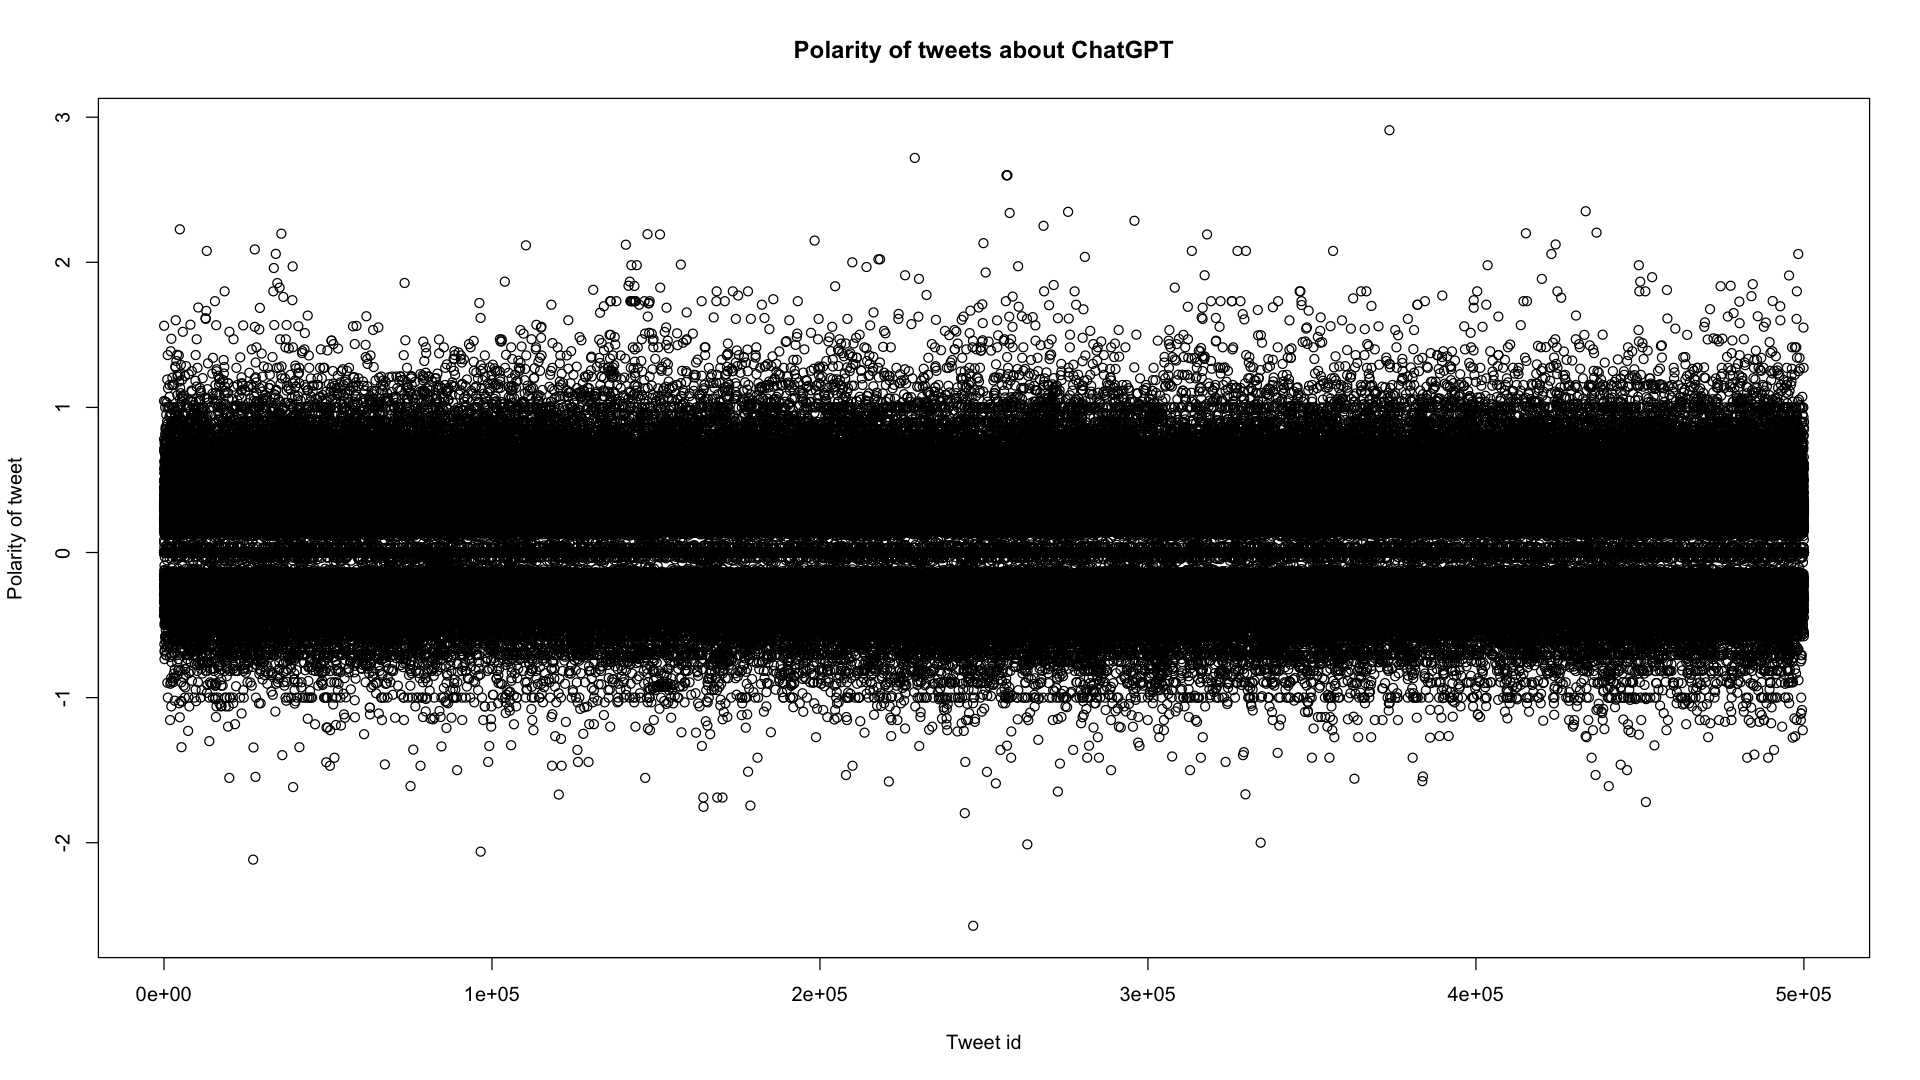

In [17]:
# représentation graphique de la polarité
# il semble y avoir un peu plus de tweets avec polarité positive
# que de tweets avec polarité négative
plot(polarity_all$polarity, main="Polarity of tweets about ChatGPT", xlab="Tweet id", ylab="Polarity of tweet")

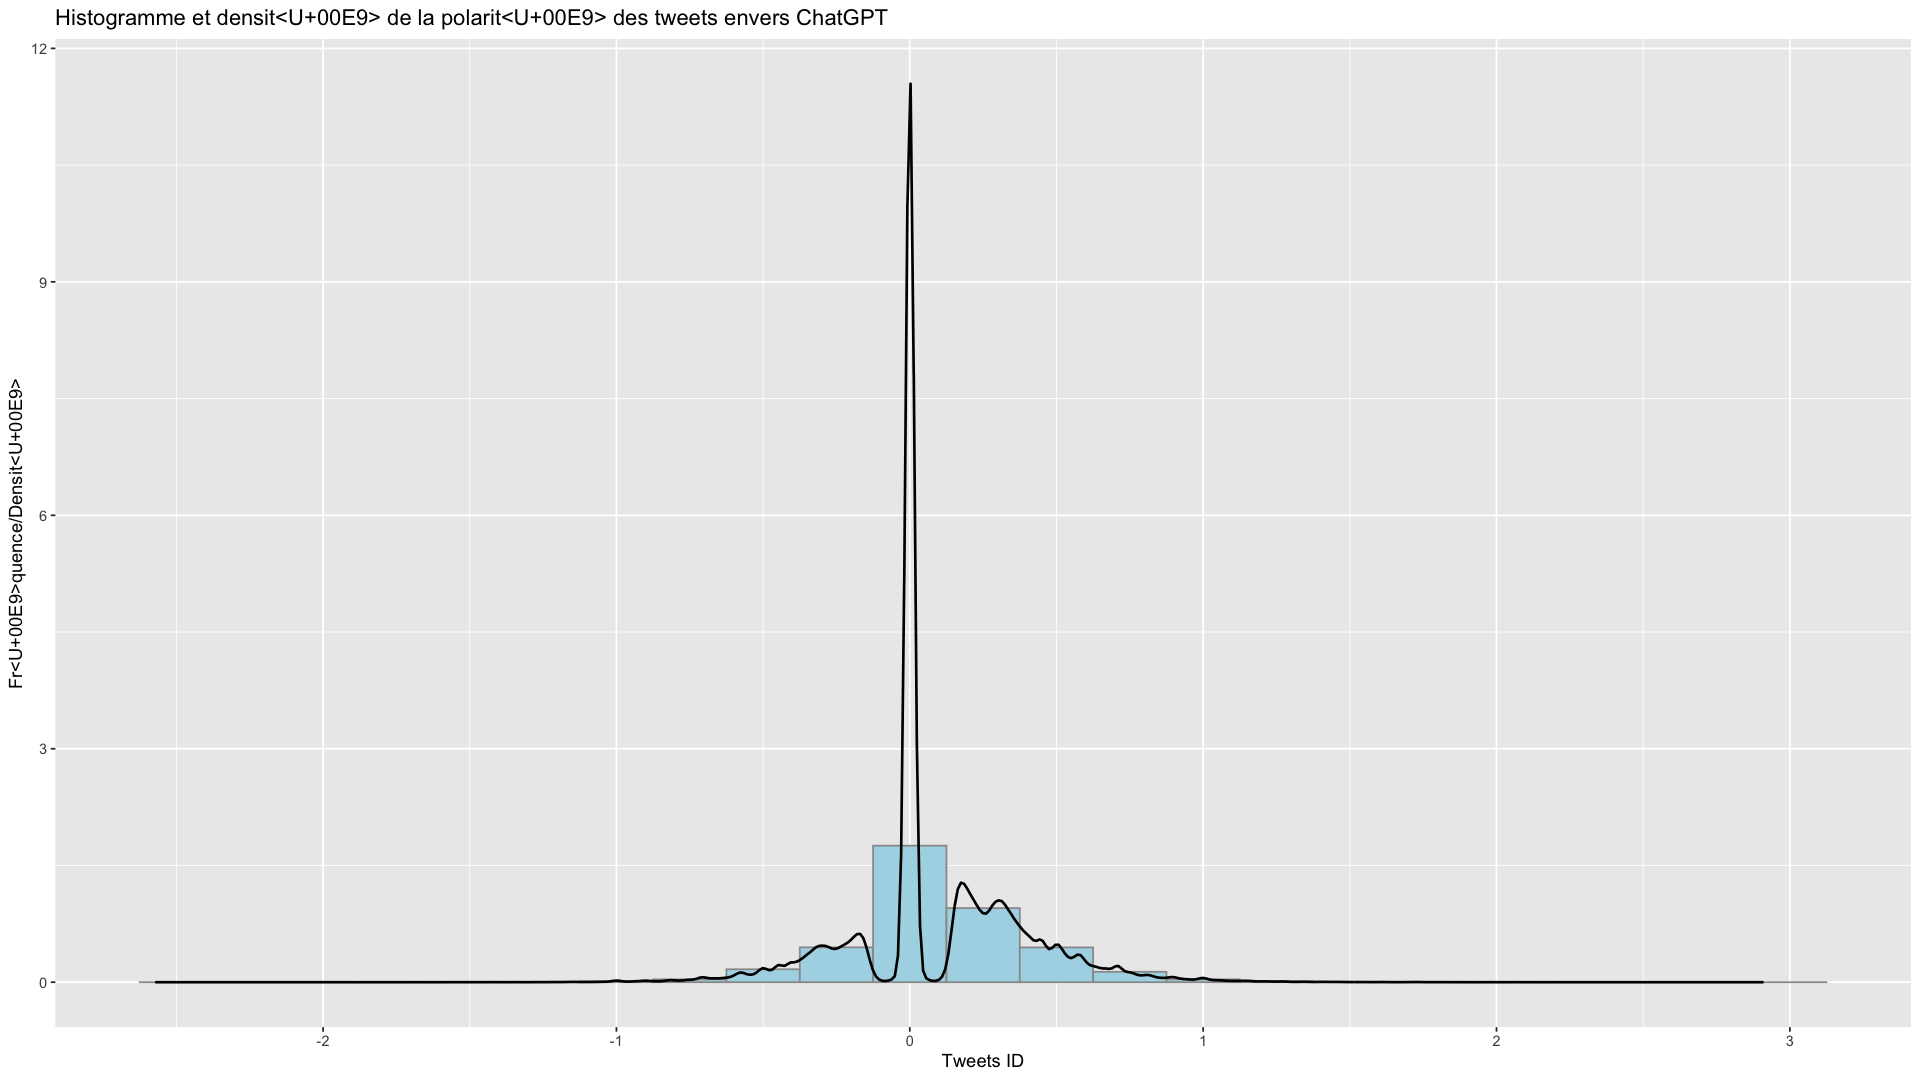

In [23]:
# Histogramme et graphique de densité de la polarité des tweets
# l'histogramme montrant une dissymétrie vers la droite
# il y a plus de tweets positifs que négatifs
ggplot(polarity_all[!is.na(polarity_all$polarity),], 
    aes(x = polarity, y = ..density..)) + 
  geom_histogram(binwidth = 0.25, fill = "lightblue", colour = "grey60") +
  geom_density(linewidth = 0.75) +
  labs(title = "Histogramme et densité de la polarité des tweets envers ChatGPT",
   x="Tweets ID", y="Fréquence/Densité")

In [25]:
# créons une variable regroupant le score de polarité en étiquette
# Neutre, Postif, Négatif selon si le score de polarité est égal à 0
# supérieur à 0, ou inférieur à 0
polarity_all$sentiment <- ifelse(polarity_all$polarity == 0, "Neutral" , 
    ifelse(polarity_all$polarity > 0, "Positive", "Negative" ))
table(polarity_all$sentiment)


Negative  Neutral Positive 
   84490   213578   199147 

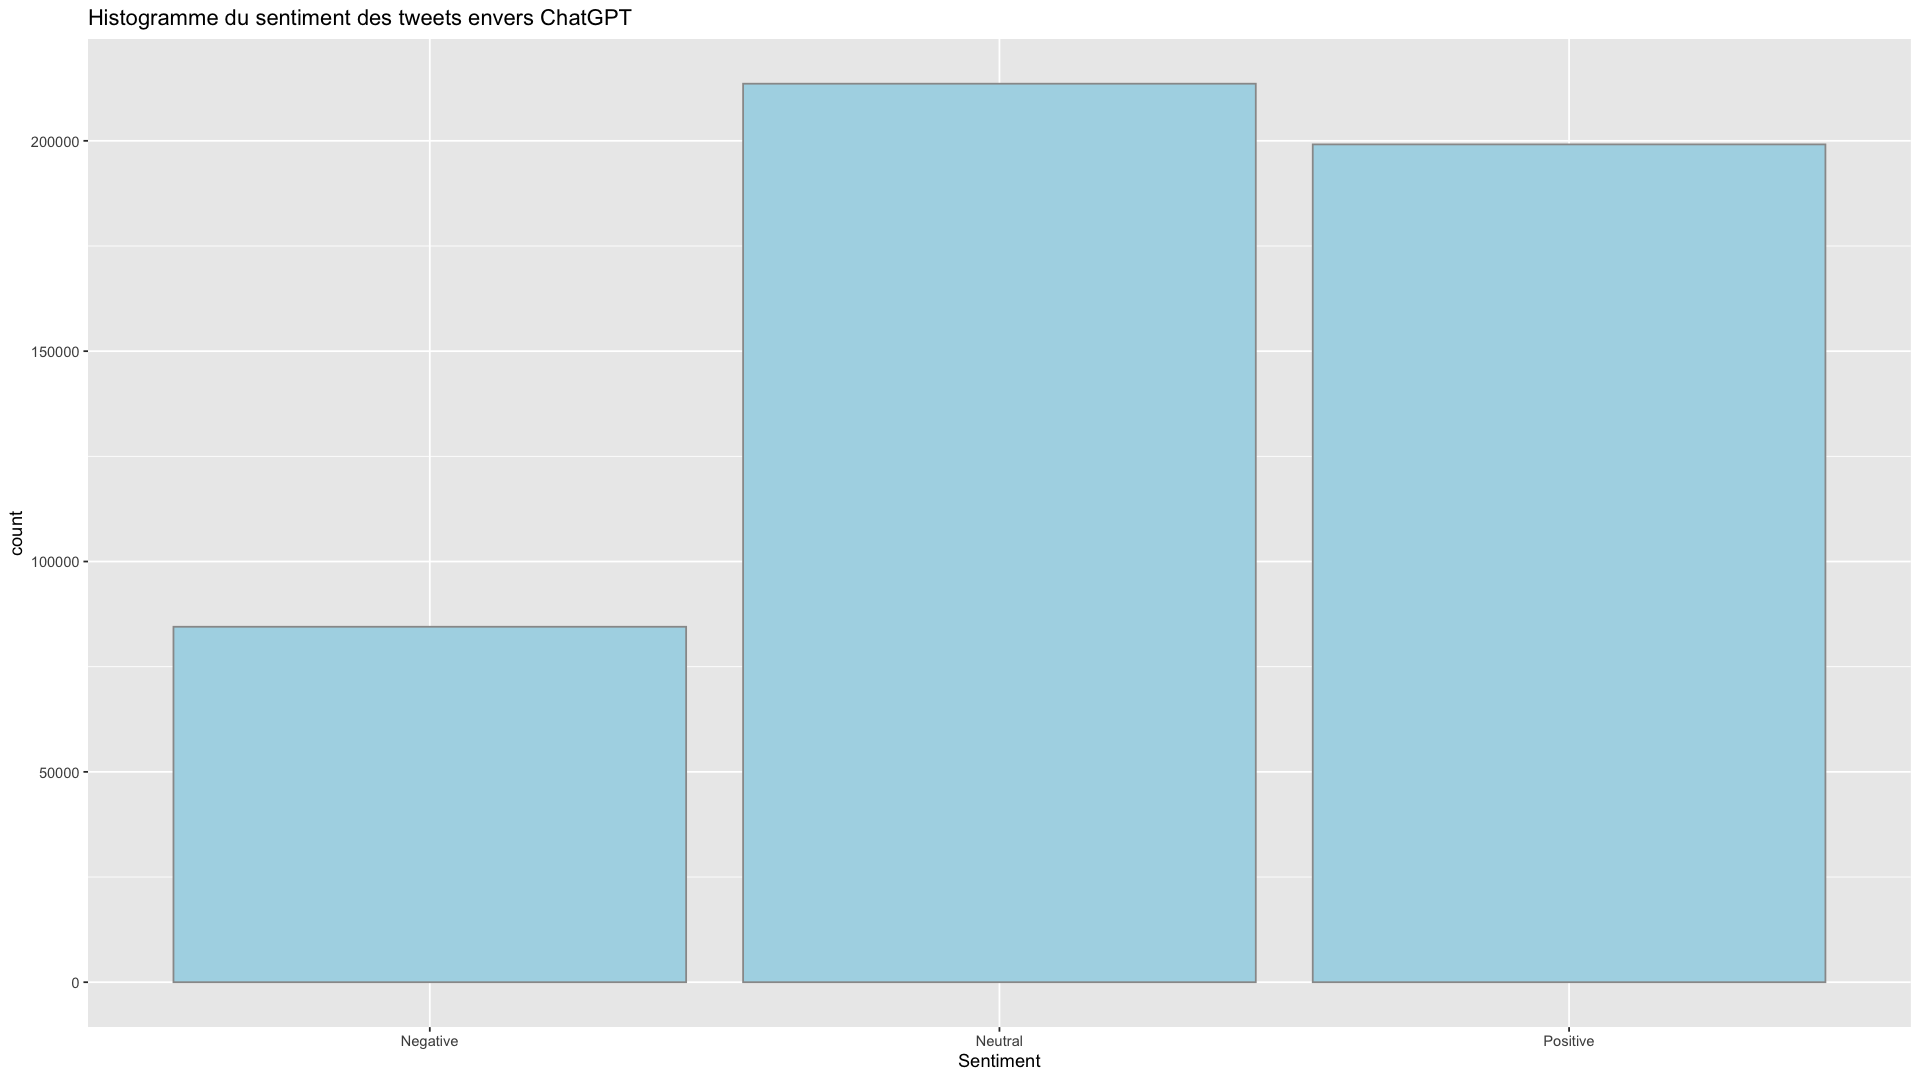

In [26]:
# représentons graphiquement cette distribution
ggplot(subset(polarity_all, !is.na(sentiment)), aes(sentiment)) + 
  geom_bar(fill = "lightblue", colour = "grey60") +
  labs(title = "Histogramme du sentiment des tweets envers ChatGPT", 
    x="Sentiment")
  

## Analyse du contenu des tweets

In [27]:
# extraction des mots positifs de l'analyse de polarité
# cette information est contenu dans la variable pos.words
# examinons les mots extraits des 10 premiers tweets
pos.words <- polarity_all$pos.words
pos.words[1:10]

[[1]]
[1] "free"

[[2]]
[1] "-"

[[3]]
[1] "-"

[[4]]
[1] "destiny"

[[5]]
[1] "elite"

[[6]]
[1] "amazing"

[[7]]
[1] "easy"

[[8]]
[1] "elite"

[[9]]
[1] "-"

[[10]]
[1] "-"

In [28]:
# extraction des mots négatifs de l'analyse de polarité
# cette information est contenu dans la variable negs.words
# examinons les mots extraits des 10 premiers tweets
neg.words <- polarity_all$neg.words
neg.words[1:10]

[[1]]
[1] "-"

[[2]]
[1] "-"

[[3]]
[1] "-"

[[4]]
[1] "-"

[[5]]
[1] "misleading"     "oversimplified" "brainless"      "screech"       

[[6]]
[1] "-"

[[7]]
[1] "-"

[[8]]
[1] "misleading"     "oversimplified" "brainless"      "screech"       

[[9]]
[1] "-"

[[10]]
[1] "limited"

In [29]:
# extraction des mots positifs les plus fréquents (20 premiers)
# à partir de la liste des mots positifs, on fait le décompte,
# les classe par ordre de fréquence décroissante et on affiche
# les 20 premiers 
polarity_all %>%
    filter(pos.words != "-") %>%
    count(pos.words) %>% 
    arrange(desc(n)) %>% 
    top_n(20)

Selecting by n


pos.words,n
<list>,<int>
like,13825
good,4502
better,4367
intelligence,4354
work,3998
free,3860
best,3512
great,3255
right,3155


In [30]:
# même opération que précédemment, pour les mots négatifs
polarity_all %>%
    filter(neg.words != "-") %>%
    count(neg.words) %>%
    arrange(desc(n)) %>%
    top_n(20)

Selecting by n


neg.words,n
<list>,<int>
wrong,2031
bad,1603
rival,1538
miss,1469
problem,1414
hype,1298
crazy,1199
hard,1146
threat,973


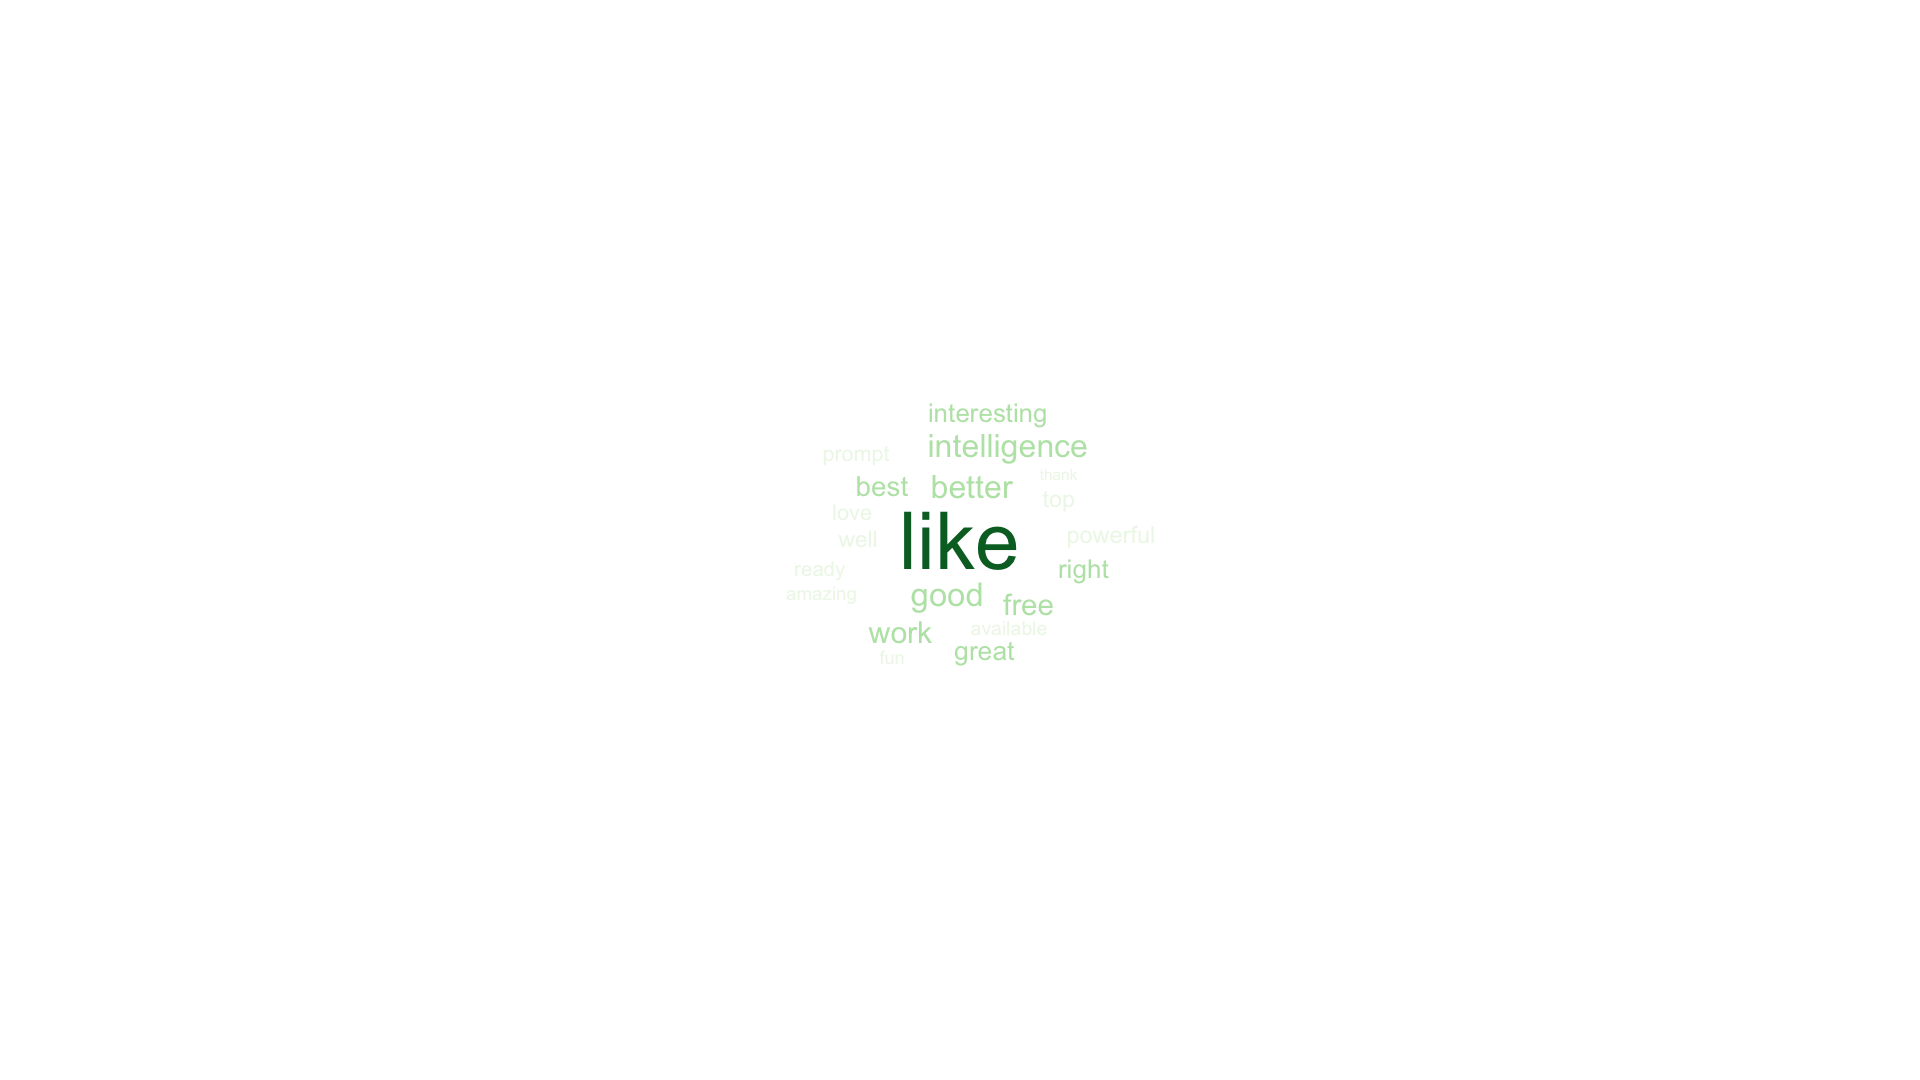

In [31]:
# représentation graphique des mots positifs les plus fréquents
# avec un nuage de mots
polarity_all %>% 
    filter(pos.words != "-") %>%
    count(pos.words) %>%
    with(wordcloud(pos.words, n, max.words=20, random.order=FALSE, 
        colors=brewer.pal(5,"Greens")))

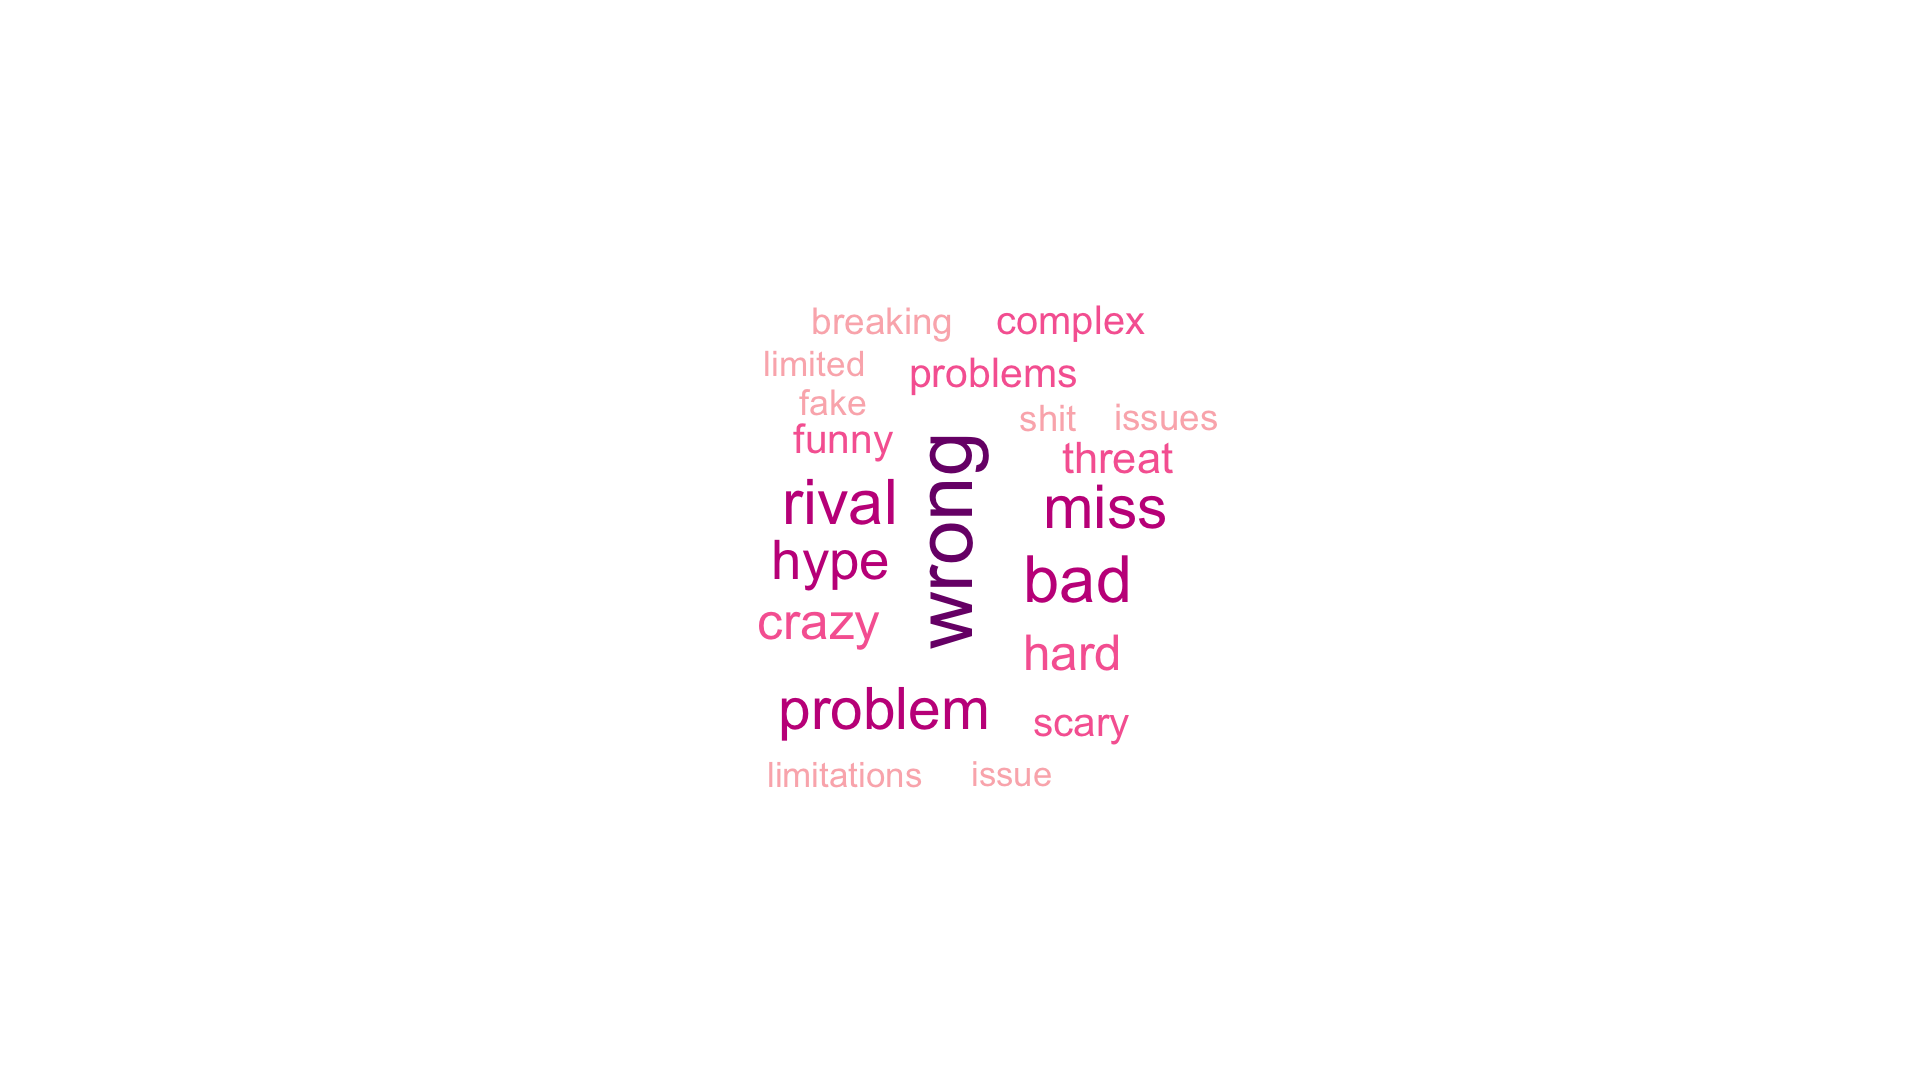

In [33]:
# même opération que précédemment, pour les mots négatifs
polarity_all %>% 
    filter(neg.words != "-") %>%
    count(neg.words) %>%
    with(wordcloud(neg.words, n, max.words=20, random.order=FALSE, 
        colors=brewer.pal(5,"RdPu")))

## Analyse des sentiments avec le lexique Bing

In [34]:
# le lexique bing est un des 3 principaux lexiques utilisés pour l'analyse 
# de sentiments. Nous l'avons choisi pour sa robustesse et sa simplicité.
# Il fait partie de la librairie tidytext.
bing <- get_sentiments("bing")

In [35]:
# regardons de quoi a l'air ce lexique, avec les 10 premiers entrées positives
bing %>% 
    filter(sentiment == "positive") %>%
    filter(row_number() <=10)

word,sentiment
<chr>,<chr>
abound,positive
abounds,positive
abundance,positive
abundant,positive
accessable,positive
accessible,positive
acclaim,positive
acclaimed,positive
acclamation,positive


In [36]:
# idem, avec les mots négatifs
bing %>%
    filter(sentiment == "negative") %>%
    filter(row_number() <=10)

word,sentiment
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative
abomination,negative
abort,negative
aborted,negative


In [37]:
# analyses de sentiments avec le lexique bing
# on extrait d'abord les mots des tweets du dataframe polarity_all
# les "tokenise" et les sauvegarde dans la variable tweets_words
tweets_words <- polarity_all %>% 
    unnest_tokens(word, text.var) %>%
    select(word)

# regardons les résultats - les 10 premiers mots
tweets_words %>% 
    filter(row_number() <= 10)

word
<chr>
free
ai
marketing
and
automation
tools
strategies
and
collaboration


In [38]:
# on peut ensuite faire l'union (inner_join) de la variable tweets_words
# avec les mots du lexique bing; les mots pouvant avoir plusieurs connotations,
# le paramètre "many-to-many" est choisi
tweets_words_count <- tweets_words %>% 
    inner_join(bing, by = join_by(word), relationship = "many-to-many") %>%
    count(word, sentiment, sort = TRUE)
tweets_words_count %>% 
    top_n(20)

Selecting by n


word,sentiment,n
<chr>,<chr>,<int>
like,positive,37526
good,positive,13052
work,positive,12633
better,positive,11339
intelligence,positive,10044
free,positive,9375
great,positive,9029
best,positive,8557
right,positive,8419


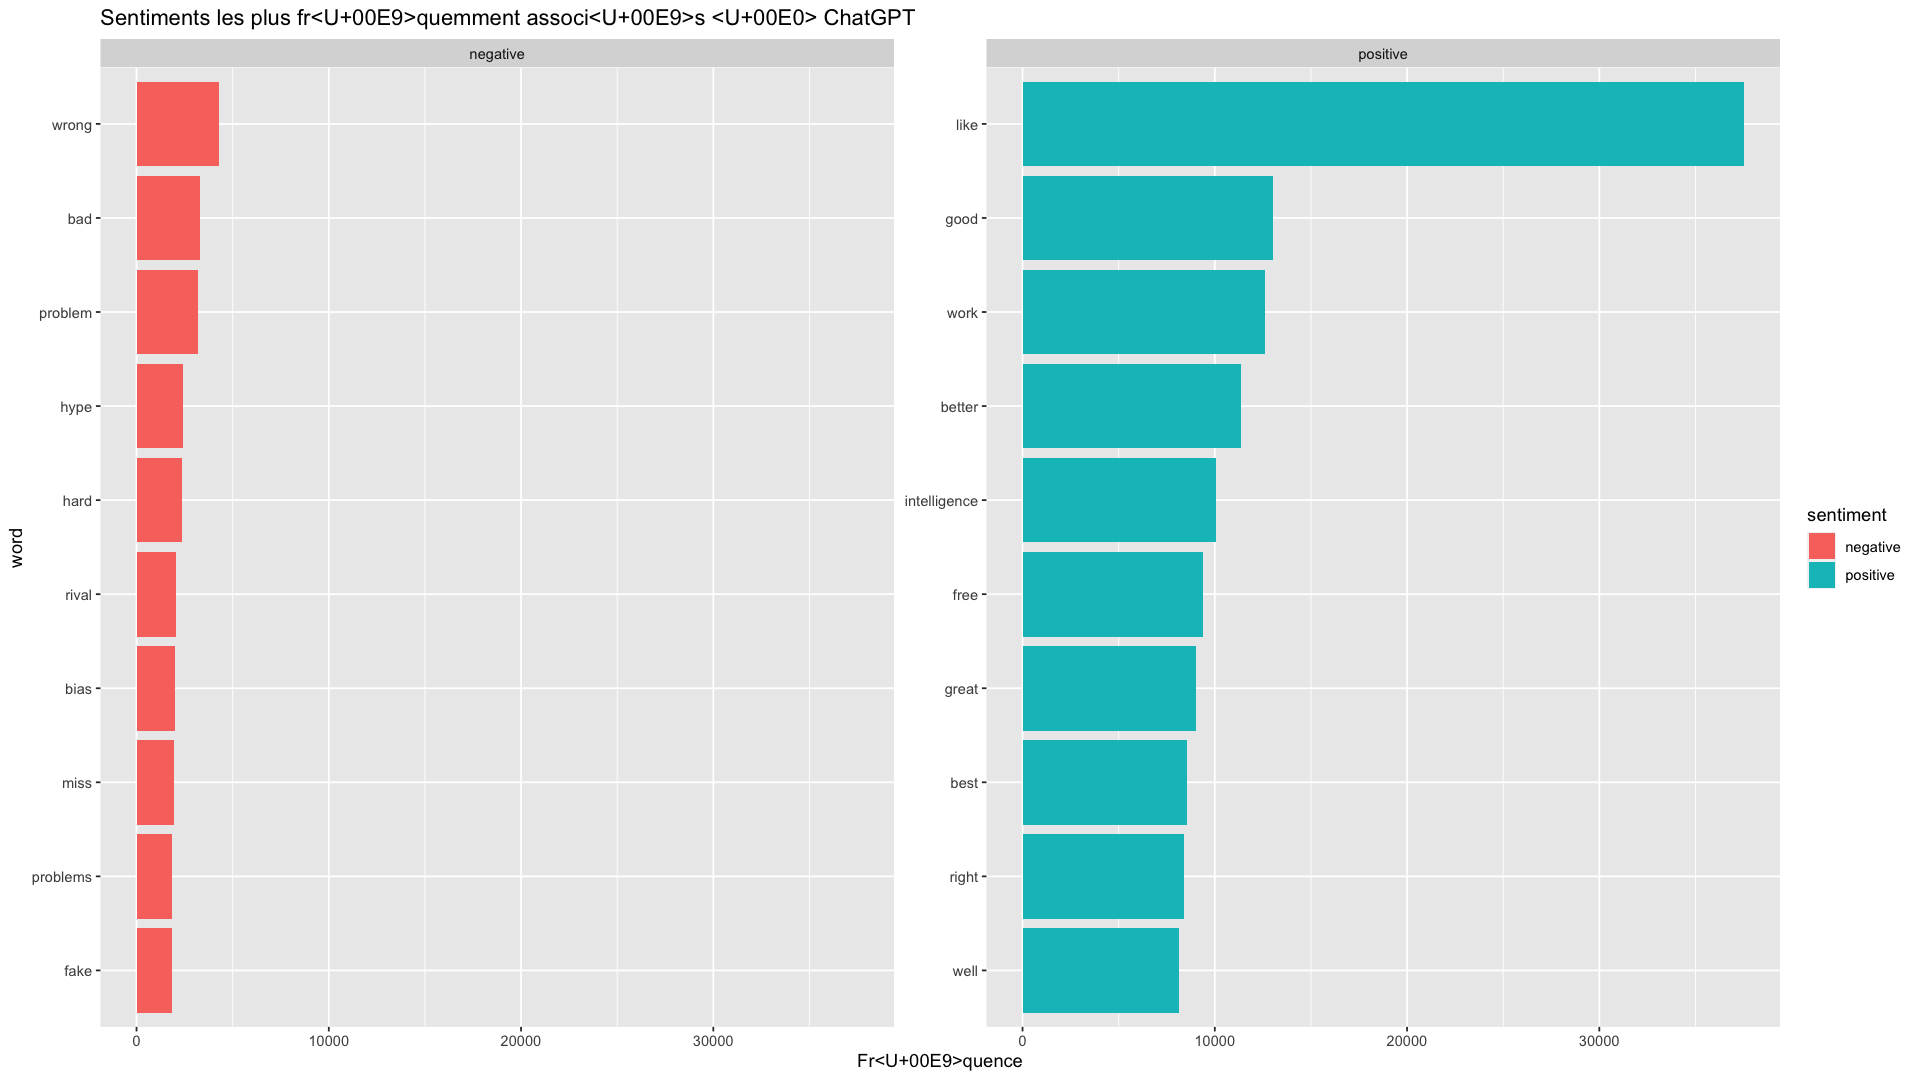

In [39]:
# affichage des résultats dans 2 graphiques parallèles
# fréquence des sentiments positifs et négatifs les plus fréquents
tweets_words_count %>%
    group_by(sentiment) %>%
    slice_max(n, n=10) %>%
    ungroup() %>%
    mutate(word = reorder(word,n)) %>%
    ggplot(aes(n,word, fill=sentiment)) + geom_col(show.legend = TRUE) +
     facet_wrap(~sentiment, scales="free_y") + 
     labs(title="Sentiments les plus frequemment associes à ChatGPT", 
        x="Frequence")

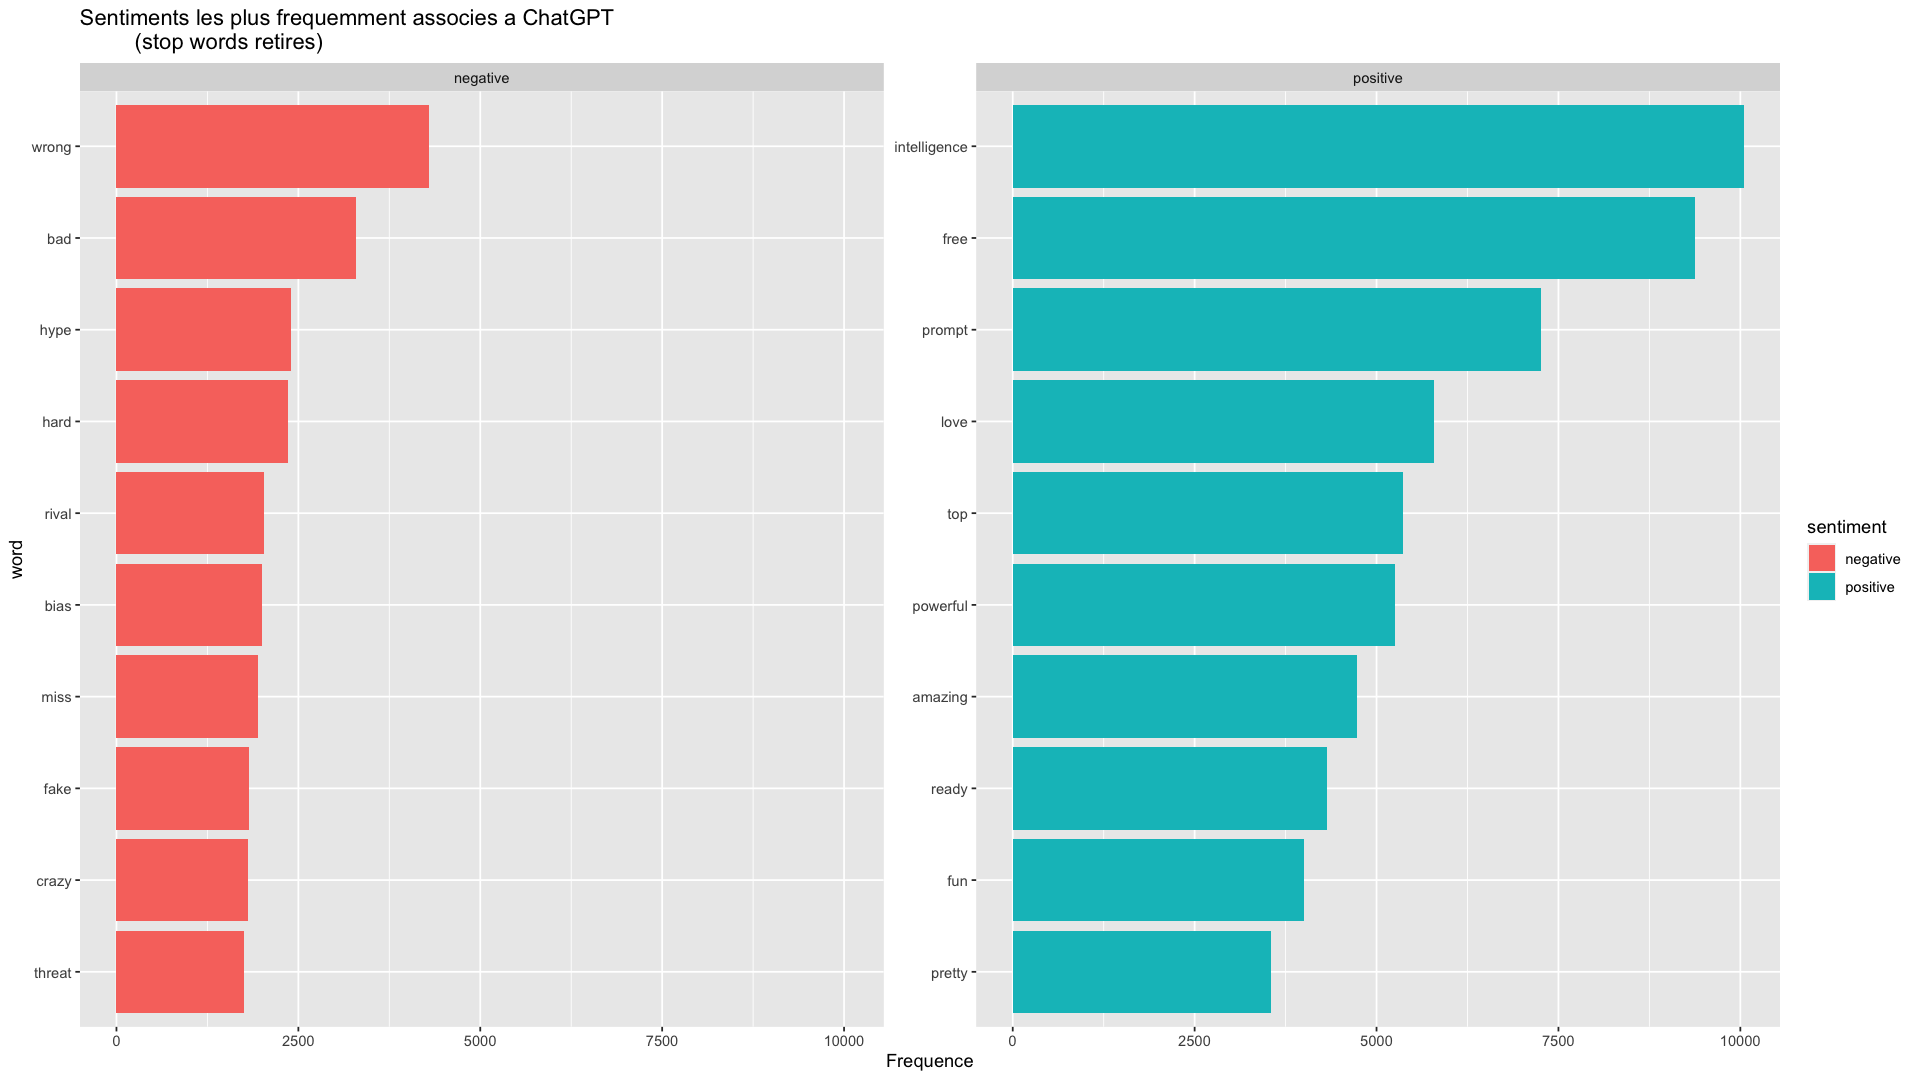

In [42]:
# même analyse, mais en retirant les "stop words", les mots fréquents de la langue
# qui n'ont pas d'utilité dans l'analyse de sentiments
tweets_words_count %>%
    anti_join(stop_words, by = join_by(word)) %>%
    group_by(sentiment) %>%
    slice_max(n, n=10) %>%
    ungroup() %>%
    mutate(word = reorder(word,n)) %>%
    ggplot(aes(n,word, fill=sentiment)) + geom_col(show.legend = TRUE) + 
        facet_wrap(~sentiment, scales="free_y") + 
        labs(title="Sentiments les plus frequemment associes a ChatGPT
         (stop words retires)", x="Frequence")

## Analyse des émotions avec le modèle de Plutchik

In [43]:
# le modèle des émotions de Plutchik permet d'analyser les émotions des tweets,
# pas seulement leur polarité. Il est disponible via le lexique nrc de tidytext.
# On affiche les 10 premières entrées pour voir comment il se présente.
nrc <- get_sentiments("nrc")
nrc %>% 
    print(n=20)

# A tibble: 13,872 x 2
   word        sentiment
   <chr>       <chr>    
 1 abacus      trust    
 2 abandon     fear     
 3 abandon     negative 
 4 abandon     sadness  
 5 abandoned   anger    
 6 abandoned   fear     
 7 abandoned   negative 
 8 abandoned   sadness  
 9 abandonment anger    
10 abandonment fear     
11 abandonment negative 
12 abandonment sadness  
13 abandonment surprise 
14 abba        positive 
15 abbot       trust    
16 abduction   fear     
17 abduction   negative 
18 abduction   sadness  
19 abduction   surprise 
20 aberrant    negative 
# i 13,852 more rows


In [45]:
# premières analyses des émotions
# on fait l'union (inner_join) de la variable tweets_words
# avec les mots du lexique nrc; les mots pouvant avoir plusieurs connotations,
# le paramètre "many-to-many" est choisi
# et affichage des 20 premières lignes
# on voit que les mots peuvent avoir de multiples connotations
tweets_words %>% 
    inner_join(nrc, by=c("word"="word"), relationship = "many-to-many") %>%
    filter(row_number() <= 20)

word,sentiment
<chr>,<chr>
court,anger
court,anticipation
court,fear
jury,trust
haven,positive
haven,trust
elite,anticipation
elite,joy
elite,positive


In [46]:
# retirons les sentiments "positive" et "negative"
# afin de ne conserver que les émotions
tweets_words_nrc <- tweets_words %>% 
    inner_join(nrc, by=c("word"="word"), relationship = "many-to-many") %>%
    filter(!sentiment %in% c("positive", "negative"))

# affichage des 20 premières lignes
tweets_words_nrc %>% filter(row_number() <=20)

word,sentiment
<chr>,<chr>
court,anger
court,anticipation
court,fear
jury,trust
haven,trust
elite,anticipation
elite,joy
elite,trust
public,anticipation


In [47]:
# regroupons les émotions et faisons leur décompte
tweets_words_nrc %>% 
    group_by(sentiment) %>%
    count(sentiment)

sentiment,n
<chr>,<int>
anger,91070
anticipation,231236
disgust,54660
fear,126590
joy,180050
sadness,83276
surprise,84553
trust,307114


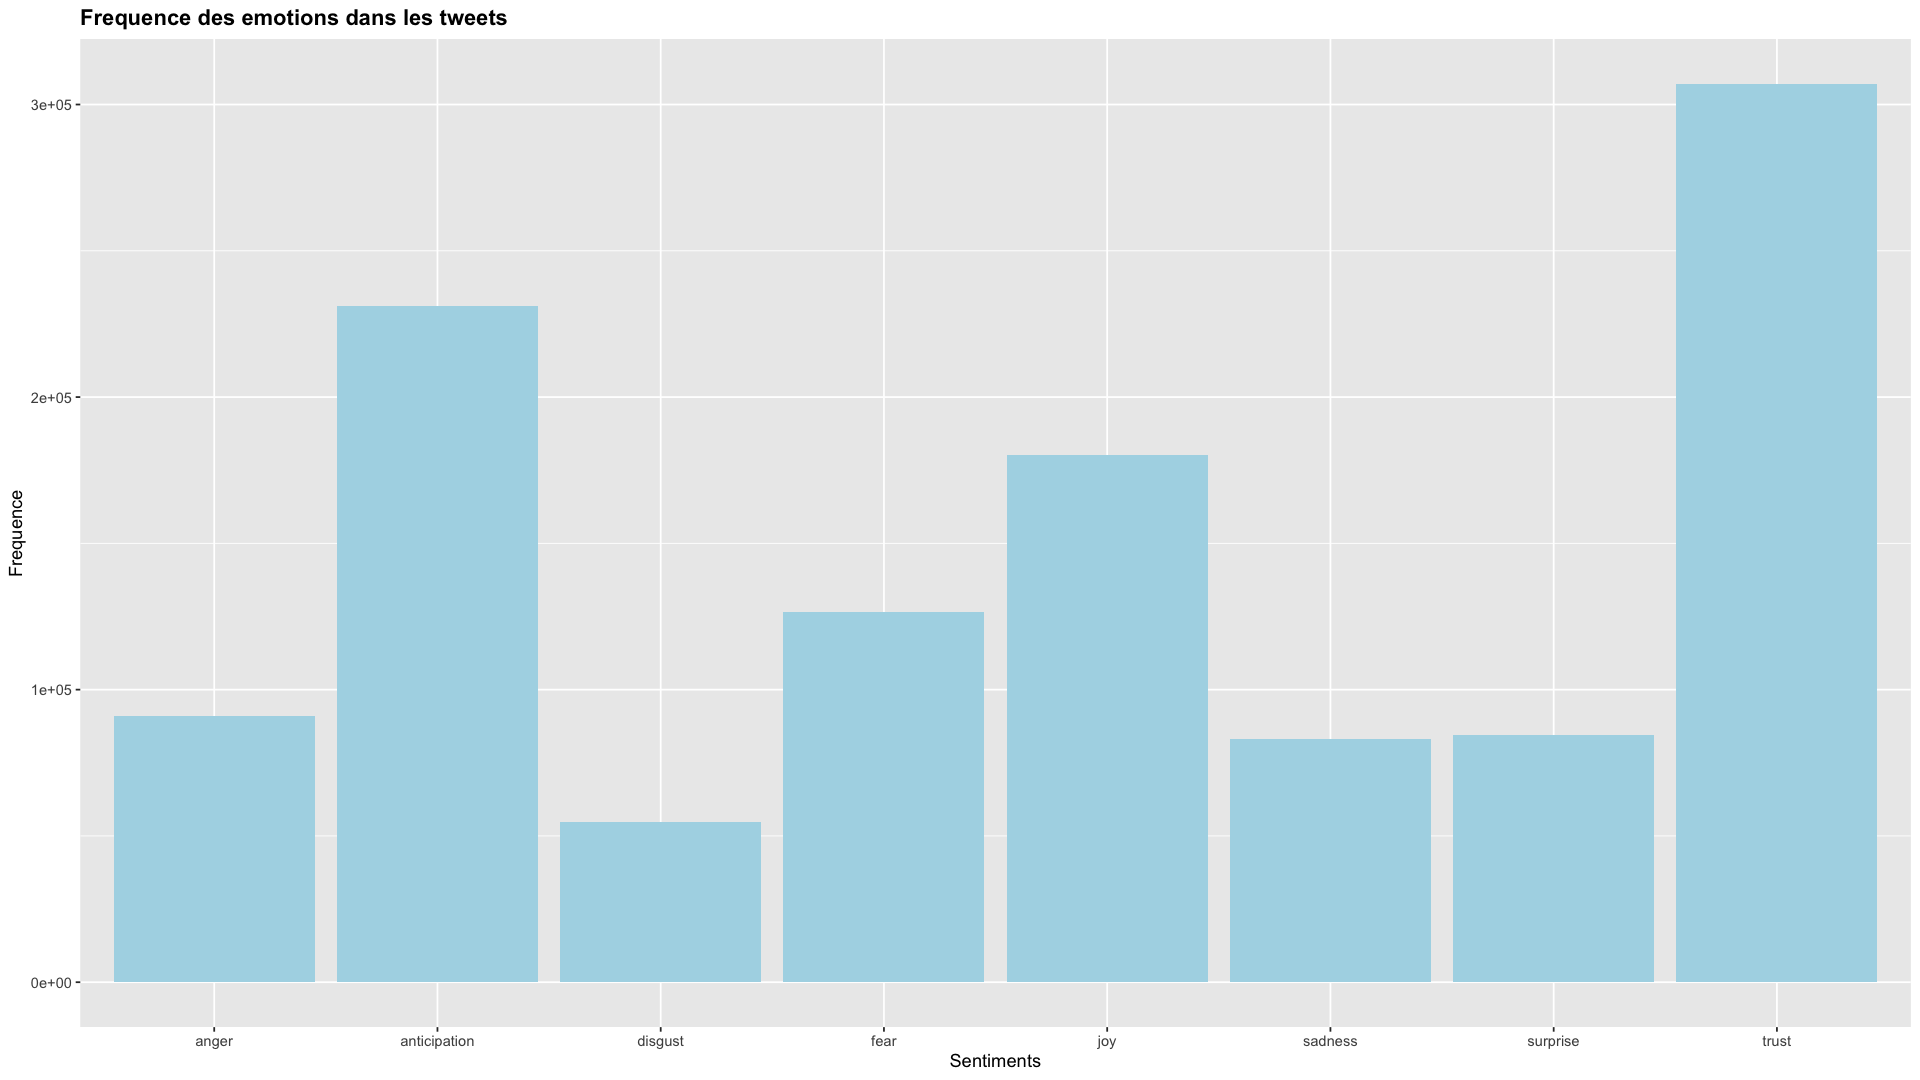

In [50]:
# représentons les résultats dans un histogramme
# on voit que la confiance (trust) est un sujet très important concernant ChatGPT
# ChatGPT suscite aussi beaucoup d'anticipation
# et que la joie (joy) et la peur (fear) sont aussi présents dans les tweets
tweets_emotions_count <- tweets_words_nrc %>%
    group_by(sentiment) %>%
    count(sentiment)

ggplot(tweets_emotions_count, aes(x=sentiment, y=n)) + 
    geom_col(fill="lightblue") + 
    labs(title="Frequence des emotions dans les tweets", x="Sentiments", 
        y="Frequence") + 
    theme(plot.title = element_text(face="bold"))

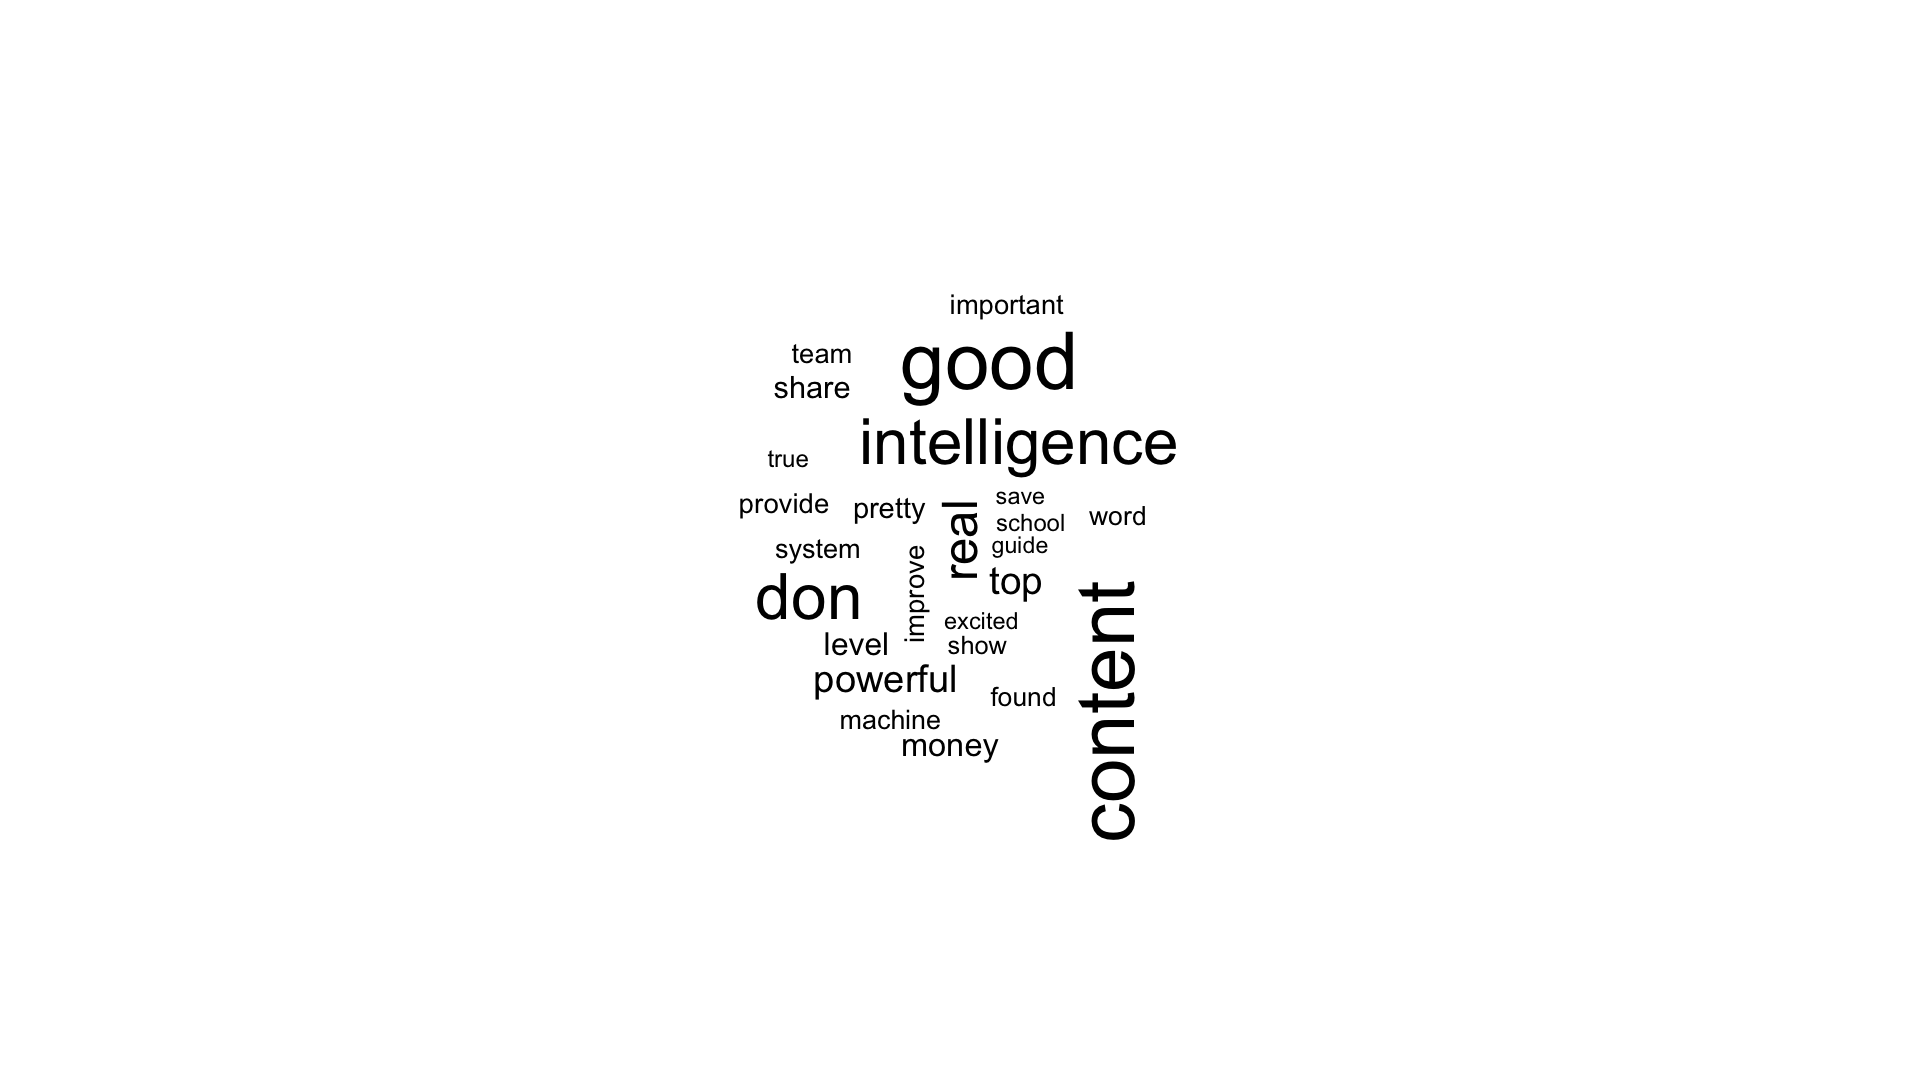

In [51]:
# quels sont les mots les plus souvent associés à la confiance (trust) ?
# on affiche les résultats avec un nuage de mots
tweets_words_nrc %>% 
    filter(sentiment == "trust") %>%
    group_by(word) %>%
    count(word) %>%
    with(wordcloud(word, n, max.words=25))

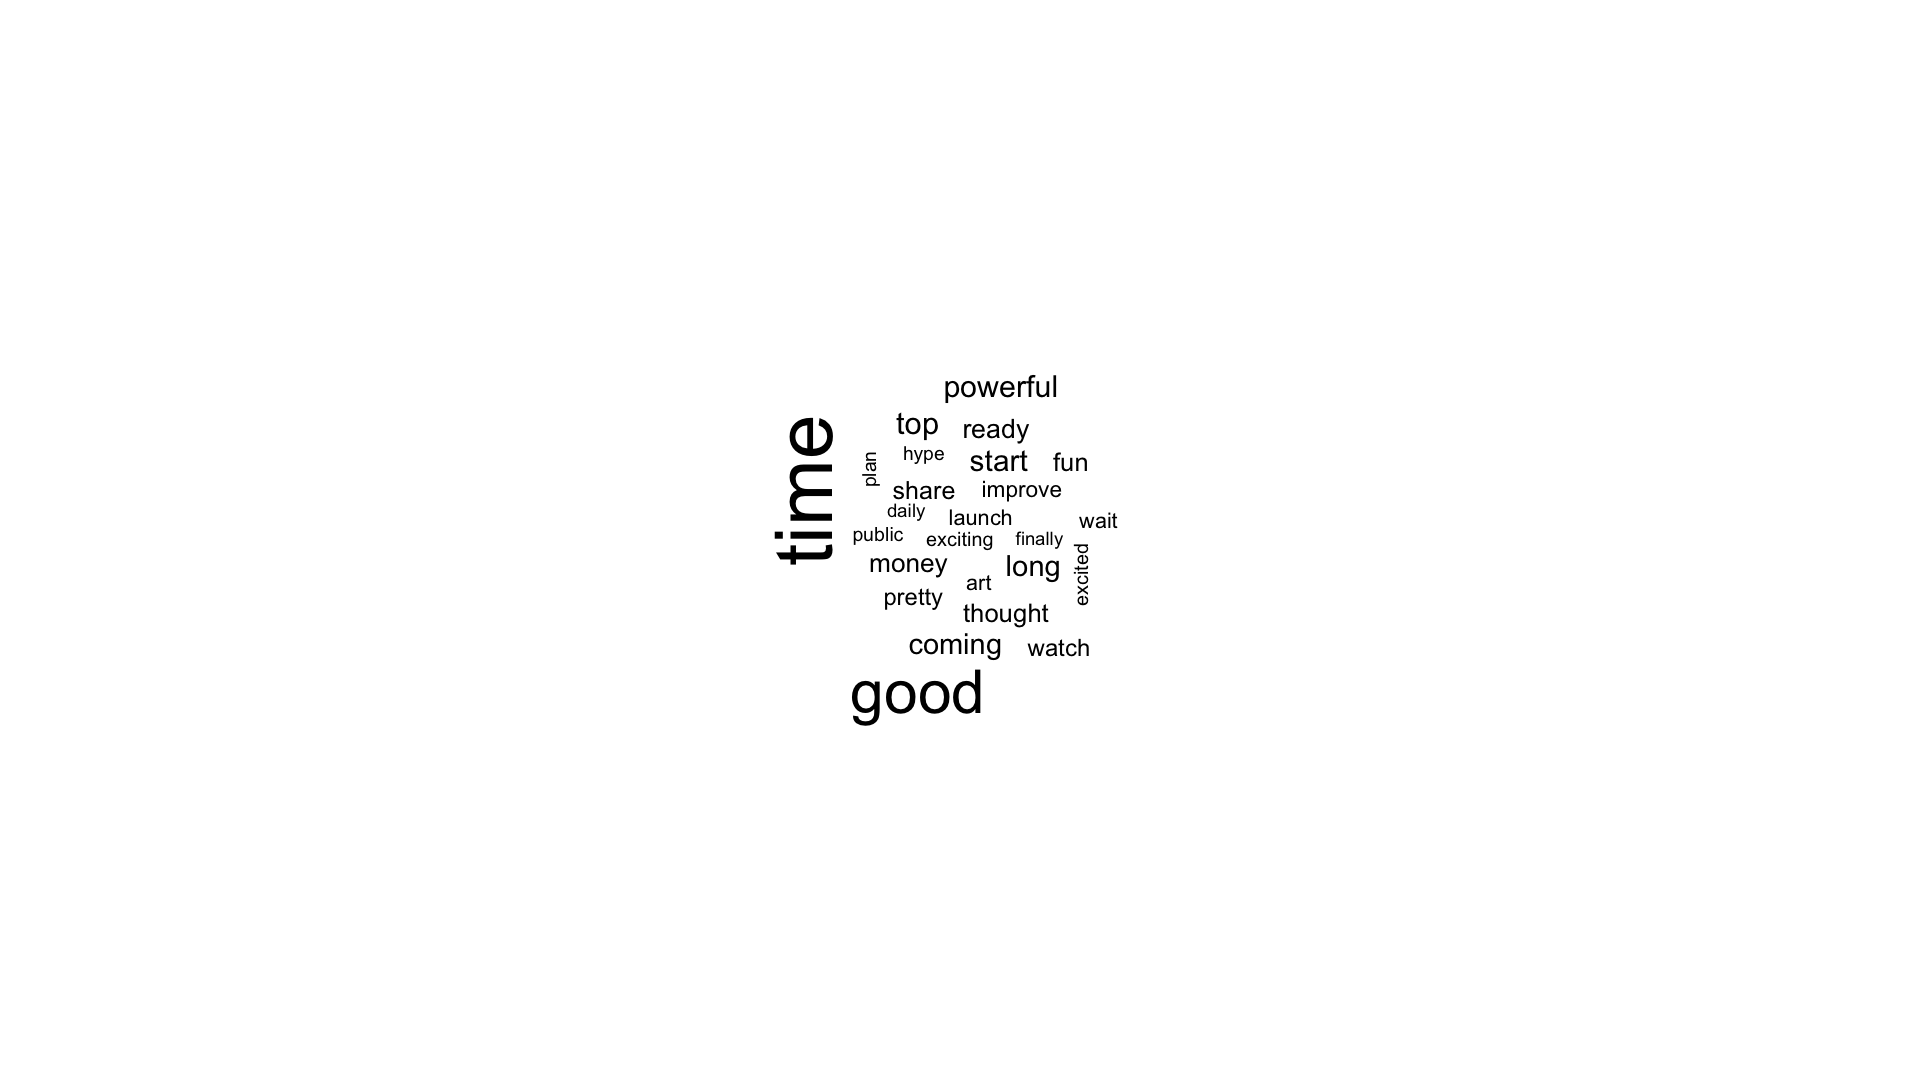

In [52]:
# quels sont les mots les plus souvent associés à l'anticipation ?
tweets_words_nrc %>%
    filter(sentiment == "anticipation") %>%
    group_by(word) %>%
    count(word) %>%
    with(wordcloud(word, n, max.words=25))

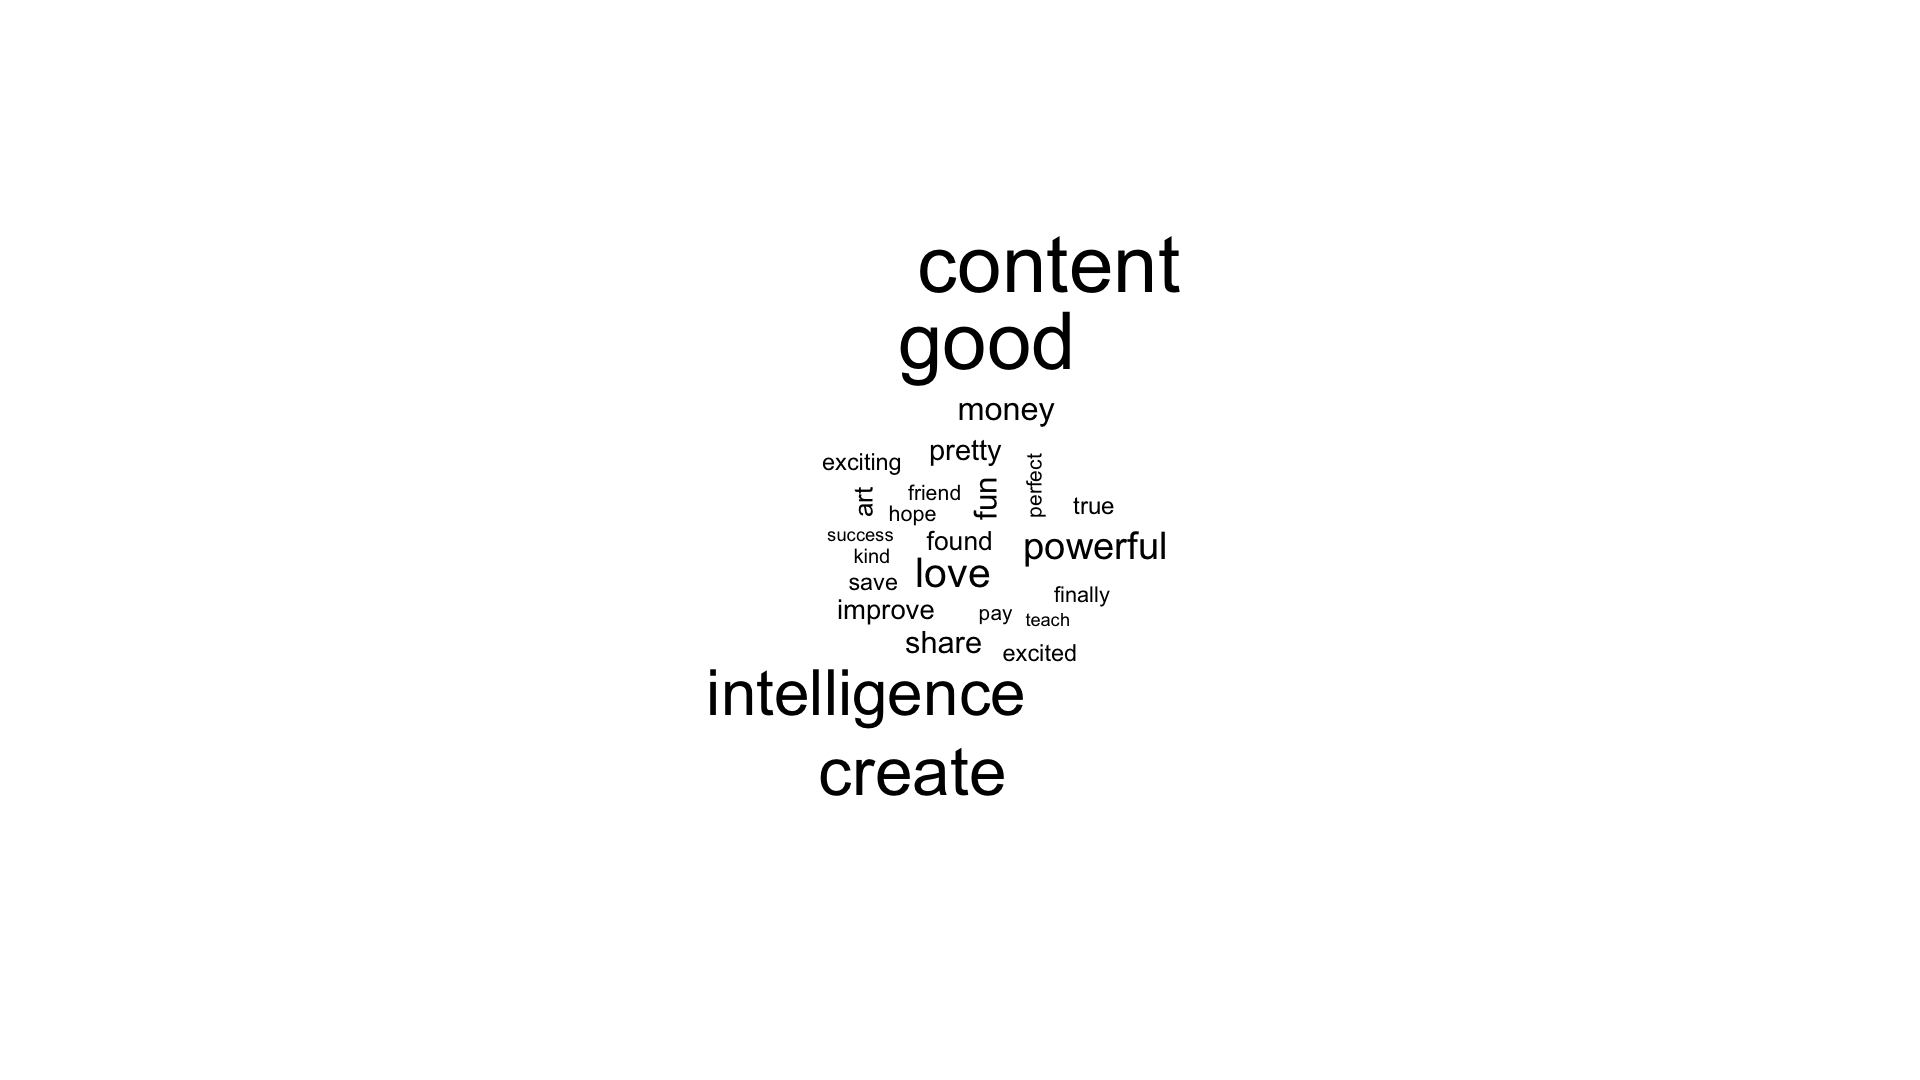

In [53]:
# quels sont les mots les plus souvent associés à la joie (joy) ?
tweets_words_nrc %>% 
    filter(sentiment == "joy") %>%
    group_by(word) %>%
    count(word) %>%
    with(wordcloud(word, n, max.words=25))

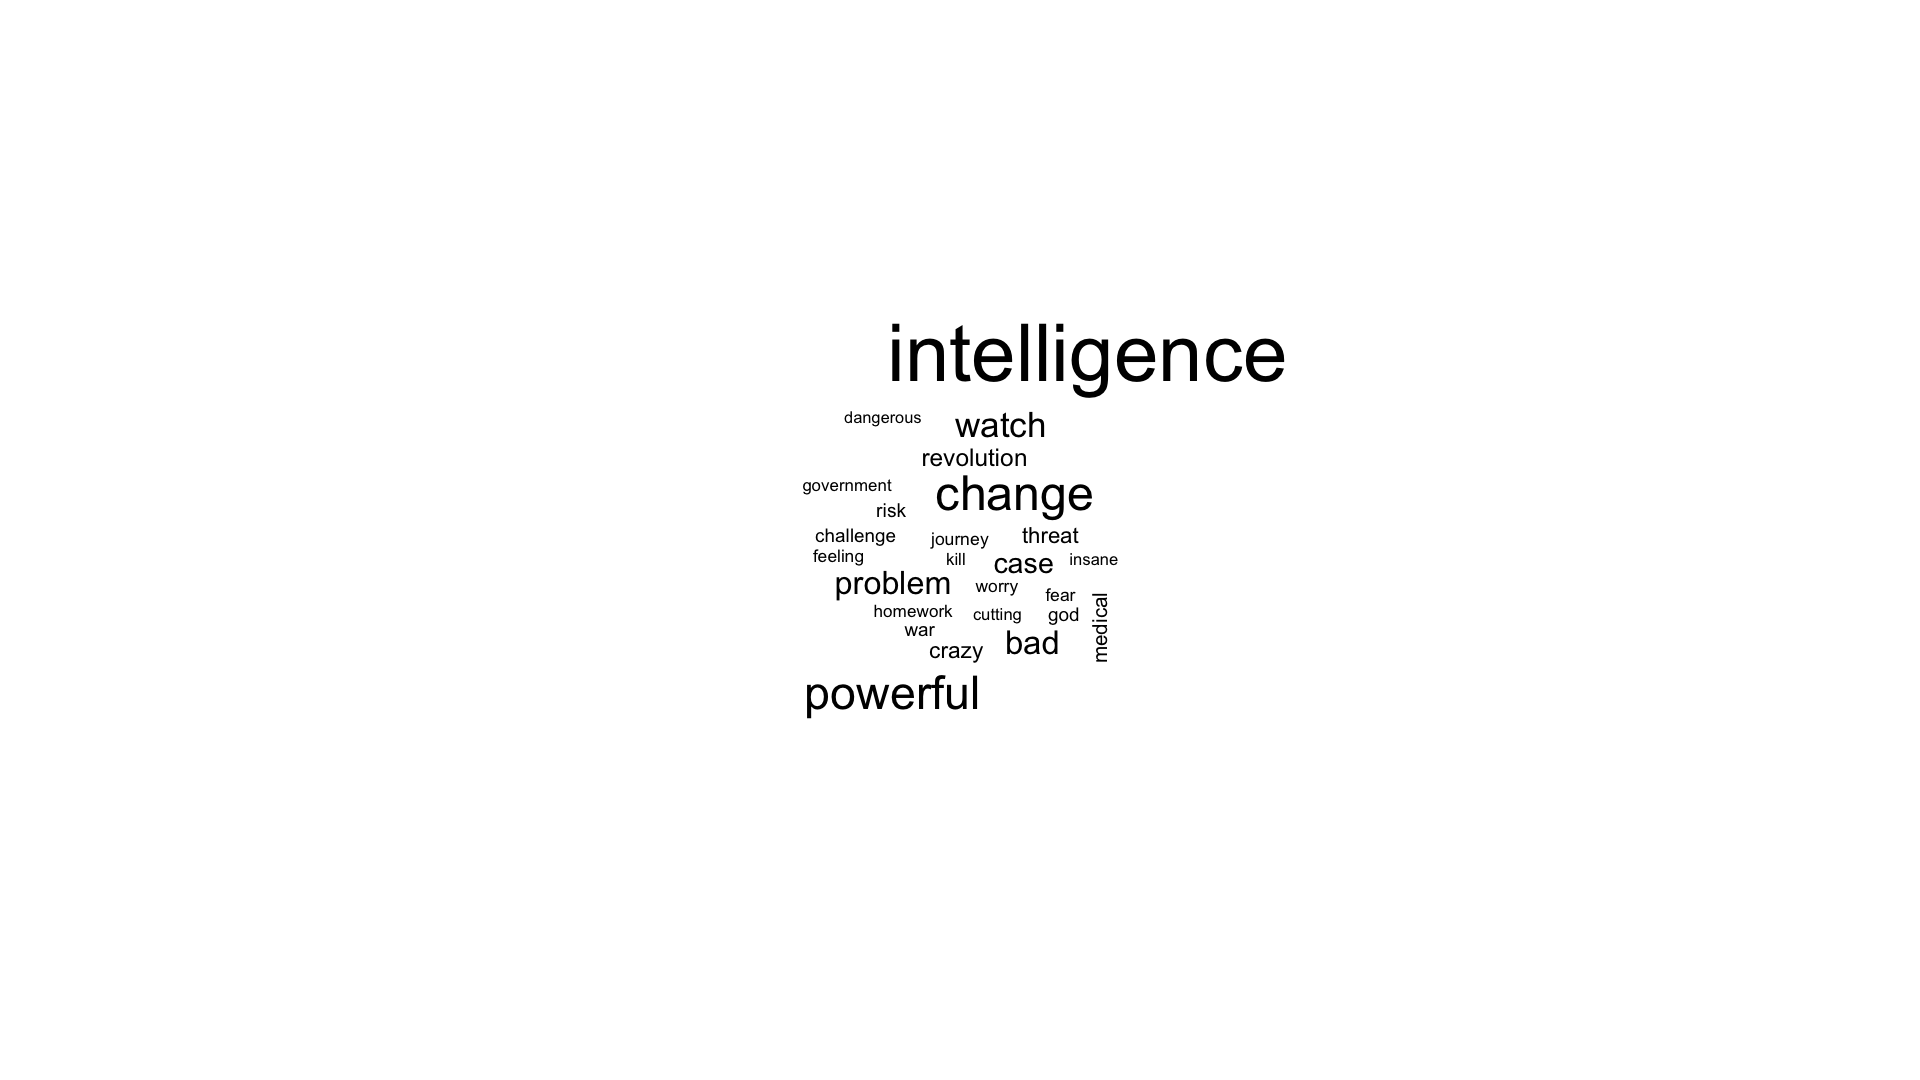

In [54]:
# quels sont les mots les plus souvent associés à la peur (fear) ?
tweets_words_nrc %>% 
    filter(sentiment == "fear") %>%
    group_by(word) %>% 
    count(word) %>%
    with(wordcloud(word, n, max.words=25))

## Analyses de l'évolution de la polarité

In [72]:
# lors des analyses précédentes, on s'intéressait aux tweets dans leur globalité
# examinons ici si les sentiments et les émotions ont évolué au cours du temps
# nous reprenons le dataframe original, attribuons un numéro de semaine aux tweets,
# puis ferons les analyses en fonction de ce numéro de semaine

In [55]:
# créons d'abord un identifiant de temps : le numéro de la semaine
tweets_df$week <- strftime(as.Date(tweets_df$date), format="%V")

# on l'ajoute ensuite au dataframe original comme nouvelle variable
tweets_df$clean_content <- tweets

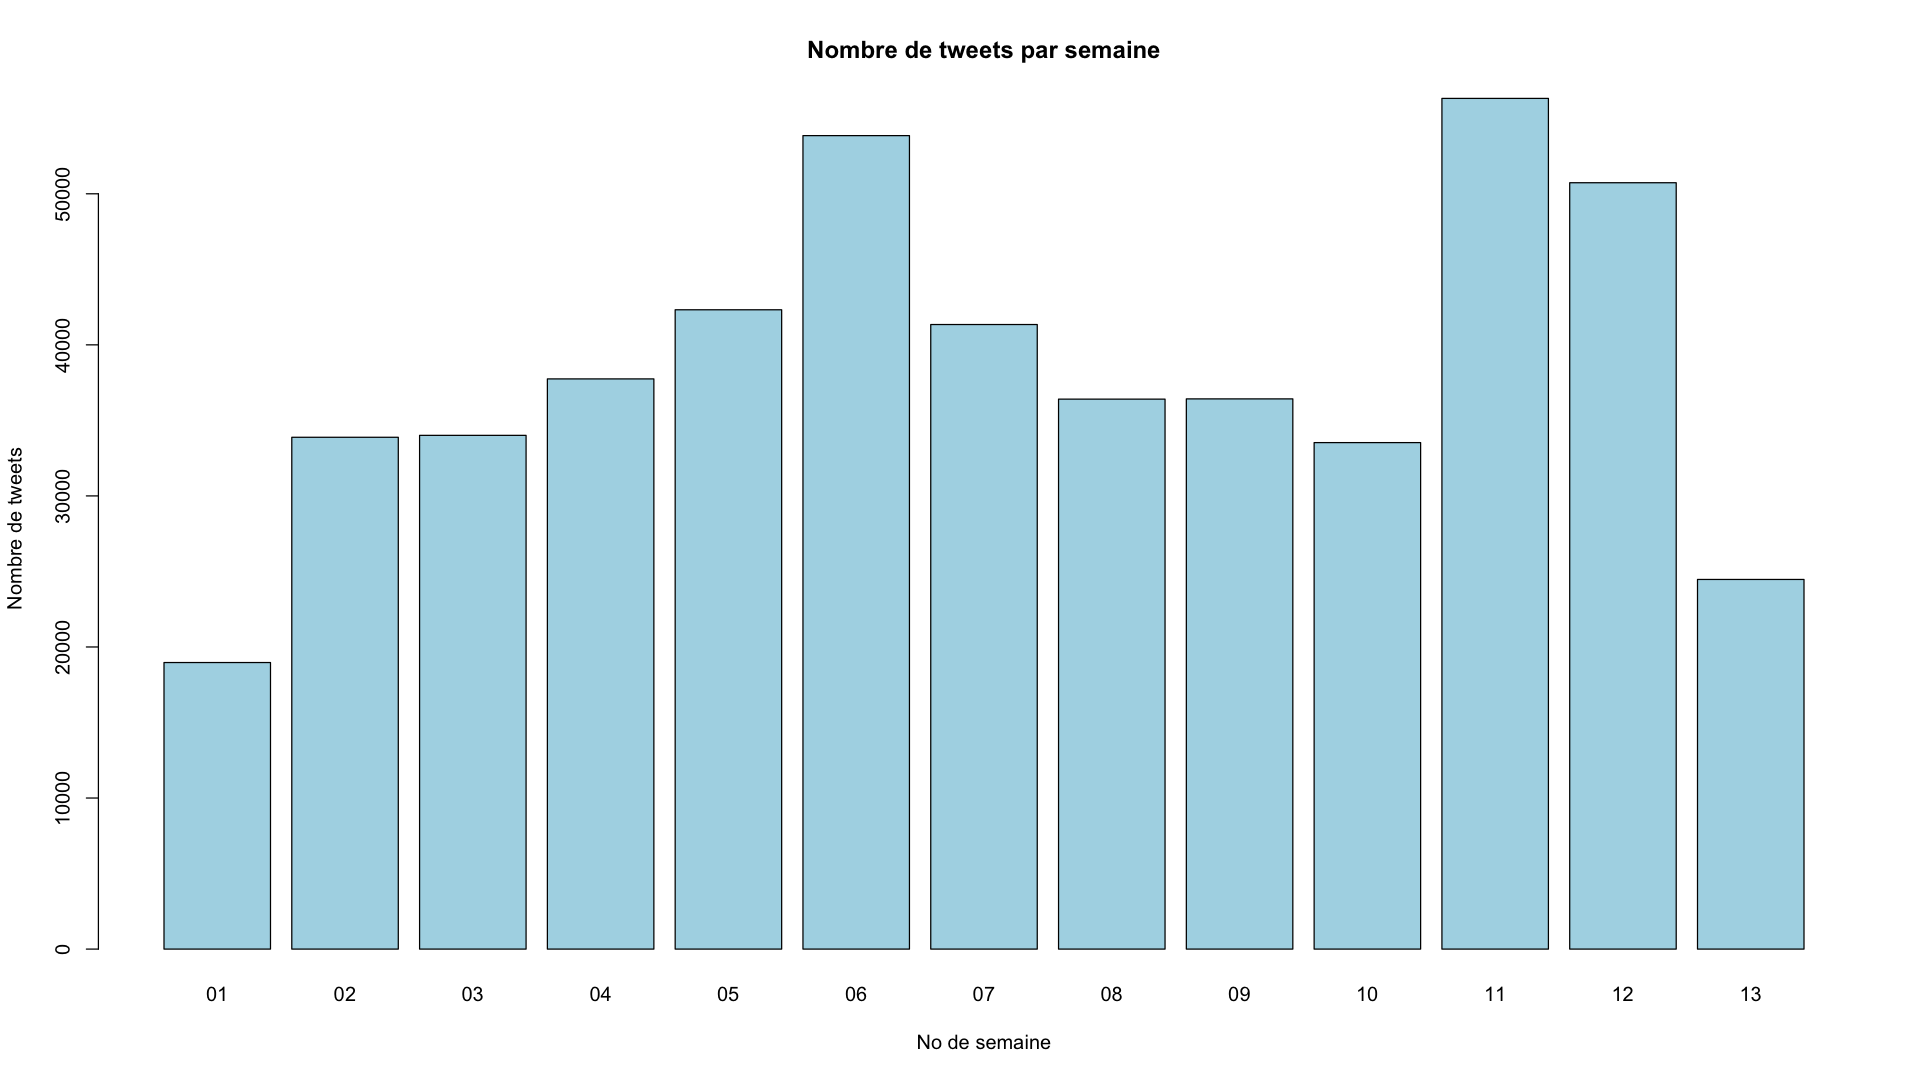

In [58]:
# examinons d'abord le nombre de tweets générés par semaine
tweets_perweek <- table(tweets_df$week)
week_numbers <- names(tweets_perweek)
barplot(tweets_perweek, main = "Nombre de tweets par semaine", 
    xlab="No de semaine", ylab="Nombre de tweets", col="lightblue")

In [68]:
# calcul de la polarité selon chacune des 13 semaine
polarity_group <- data.frame()

for(x in week_numbers){
    # on prend ici la variable $group, qui contient les moyennes des polarités
    y = polarity(tweets_df[tweets_df$week == x,]$clean_content)$group
    y$week <- x
    if(x == "01")
        polarity_group <- y
    else polarity_group <- rbind(polarity_group, y)
}
polarity_group <- select(polarity_group, -c("all"))

In [69]:
# examen des résultats
polarity_group

total.sentences,total.words,ave.polarity,sd.polarity,stan.mean.polarity,week
<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
19004,384537,0.09930730,0.3011708,0.3297375,01
33916,678274,0.09518272,0.2966030,0.3209095,02
34043,677419,0.09267103,0.3003521,0.3085413,03
37780,741621,0.09275216,0.2932853,0.3162524,04
42356,816676,0.08536160,0.2992280,0.2852728,05
53885,1035084,0.07824385,0.3000315,0.2607854,06
41380,801755,0.08805319,0.3085823,0.2853475,07
36441,705861,0.09193129,0.3073900,0.2990705,08
36457,704346,0.10262666,0.2968963,0.3456650,09


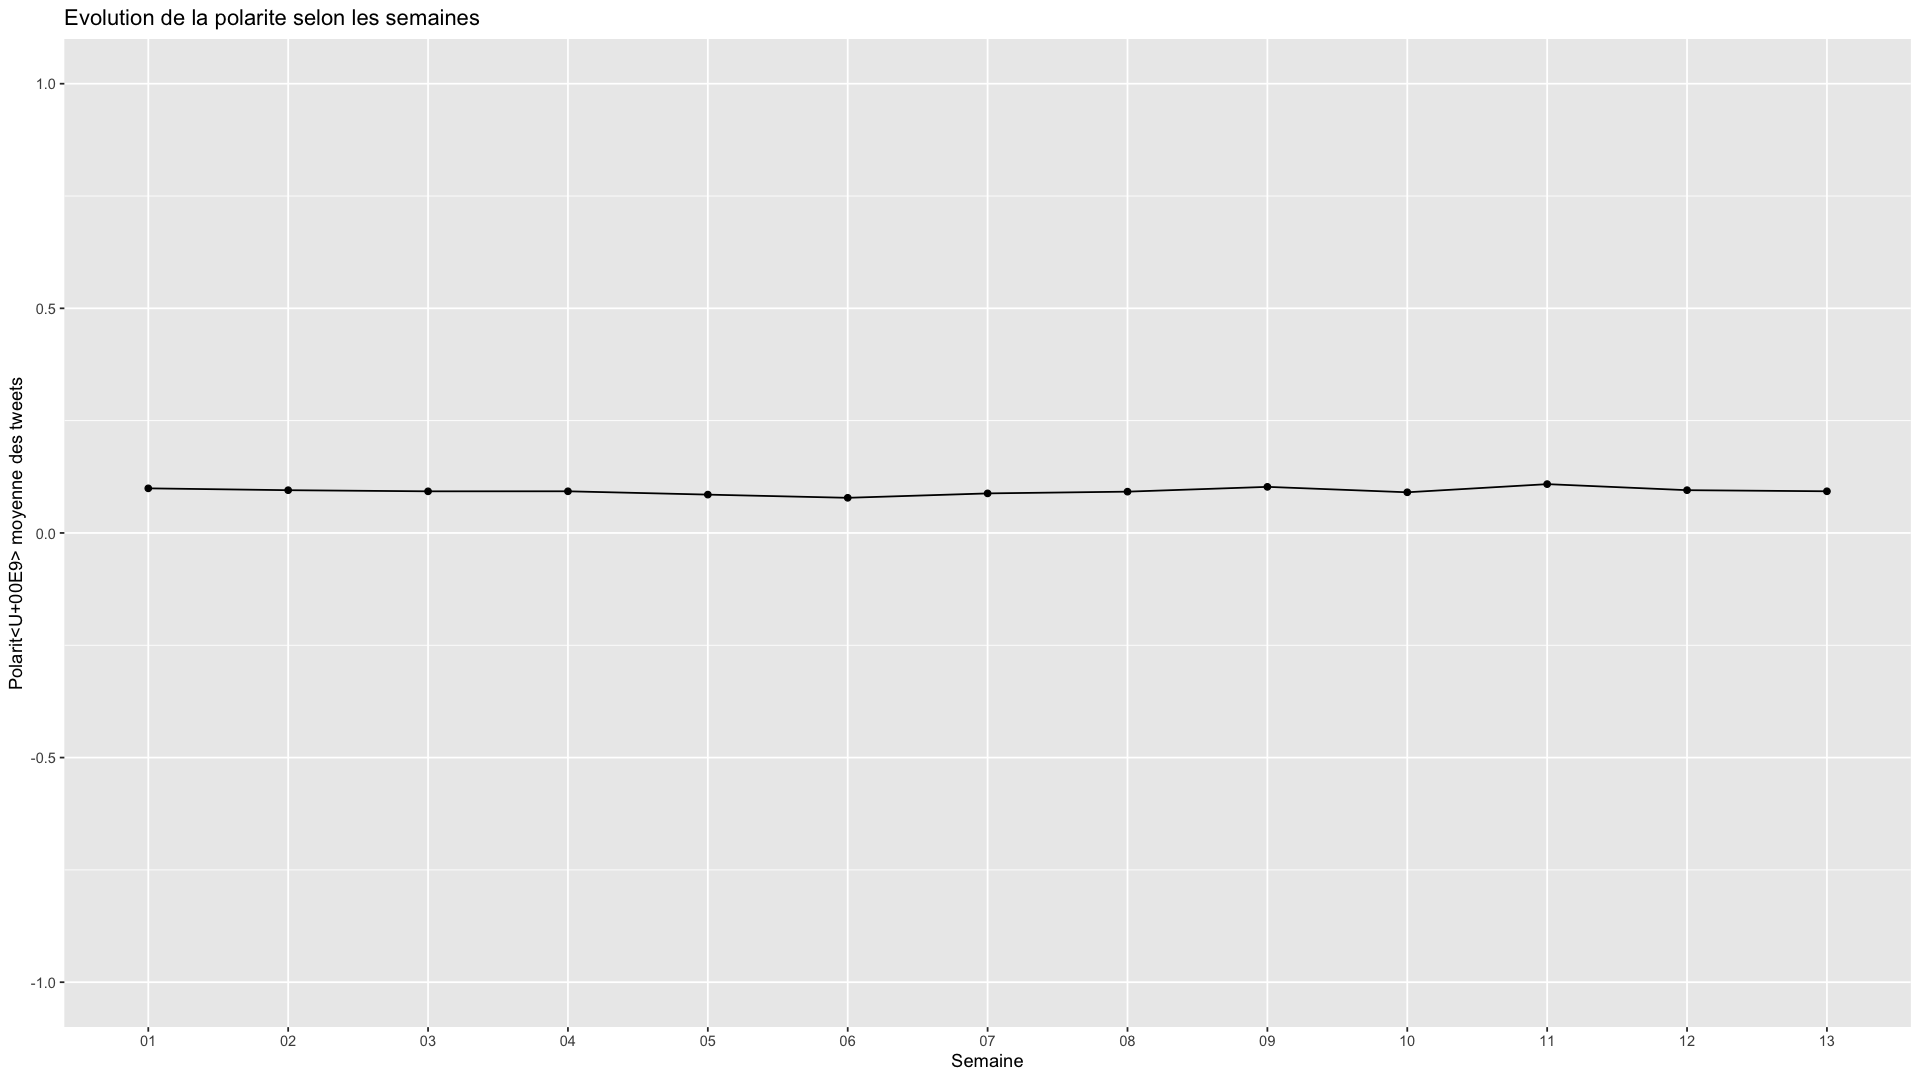

In [70]:
# graphique de l'évolution de la polarité à travers les semaines
# on voit que la polarité moyenne par semaine est légèrement au-dessus de 0
# et qu'elle n'a pas changé beaucoup à travers les 13 semaines
ggplot(polarity_group, aes(x=week, y=ave.polarity, group=1)) + 
    geom_point() + geom_line() + ylim(-1,1) + 
    labs(title="Evolution de la polarite selon les semaines", x="Semaine", 
        y="Polarité moyenne des tweets")

In [71]:
# calcul des sentiments à travers les 13 semaines
polarity_group <- data.frame()

for(x in week_numbers){
    # on prend ici la variable $group, qui contient les moyennes des polarités
    polarity_df = polarity(tweets_df[tweets_df$week == x,]$clean_content)$all
    # on crée une variable sentiment, selon si la polarité est
    # Neutre, Positive ou Négative
    polarity_df$sentiment <- ifelse(polarity_df$polarity == 0, "Neutral" ,
        ifelse(polarity_df$polarity > 0, "Positive", "Negative" ))
    y <- as.data.frame(t(table(polarity_df$sentiment)))
    y$Var1 <- x
    if(x == "01")
        polarity_sentiments <- y
    else polarity_sentiments <- rbind(polarity_sentiments, y)
}
colnames(polarity_sentiments) <- c("Week","Sentiment","Freq")
polarity_sentiments

Week,Sentiment,Freq
<chr>,<fct>,<int>
01,Negative,3065
01,Neutral,8121
01,Positive,7691
02,Negative,5543
02,Neutral,14761
02,Positive,13460
03,Negative,5773
03,Neutral,14503
03,Positive,13606


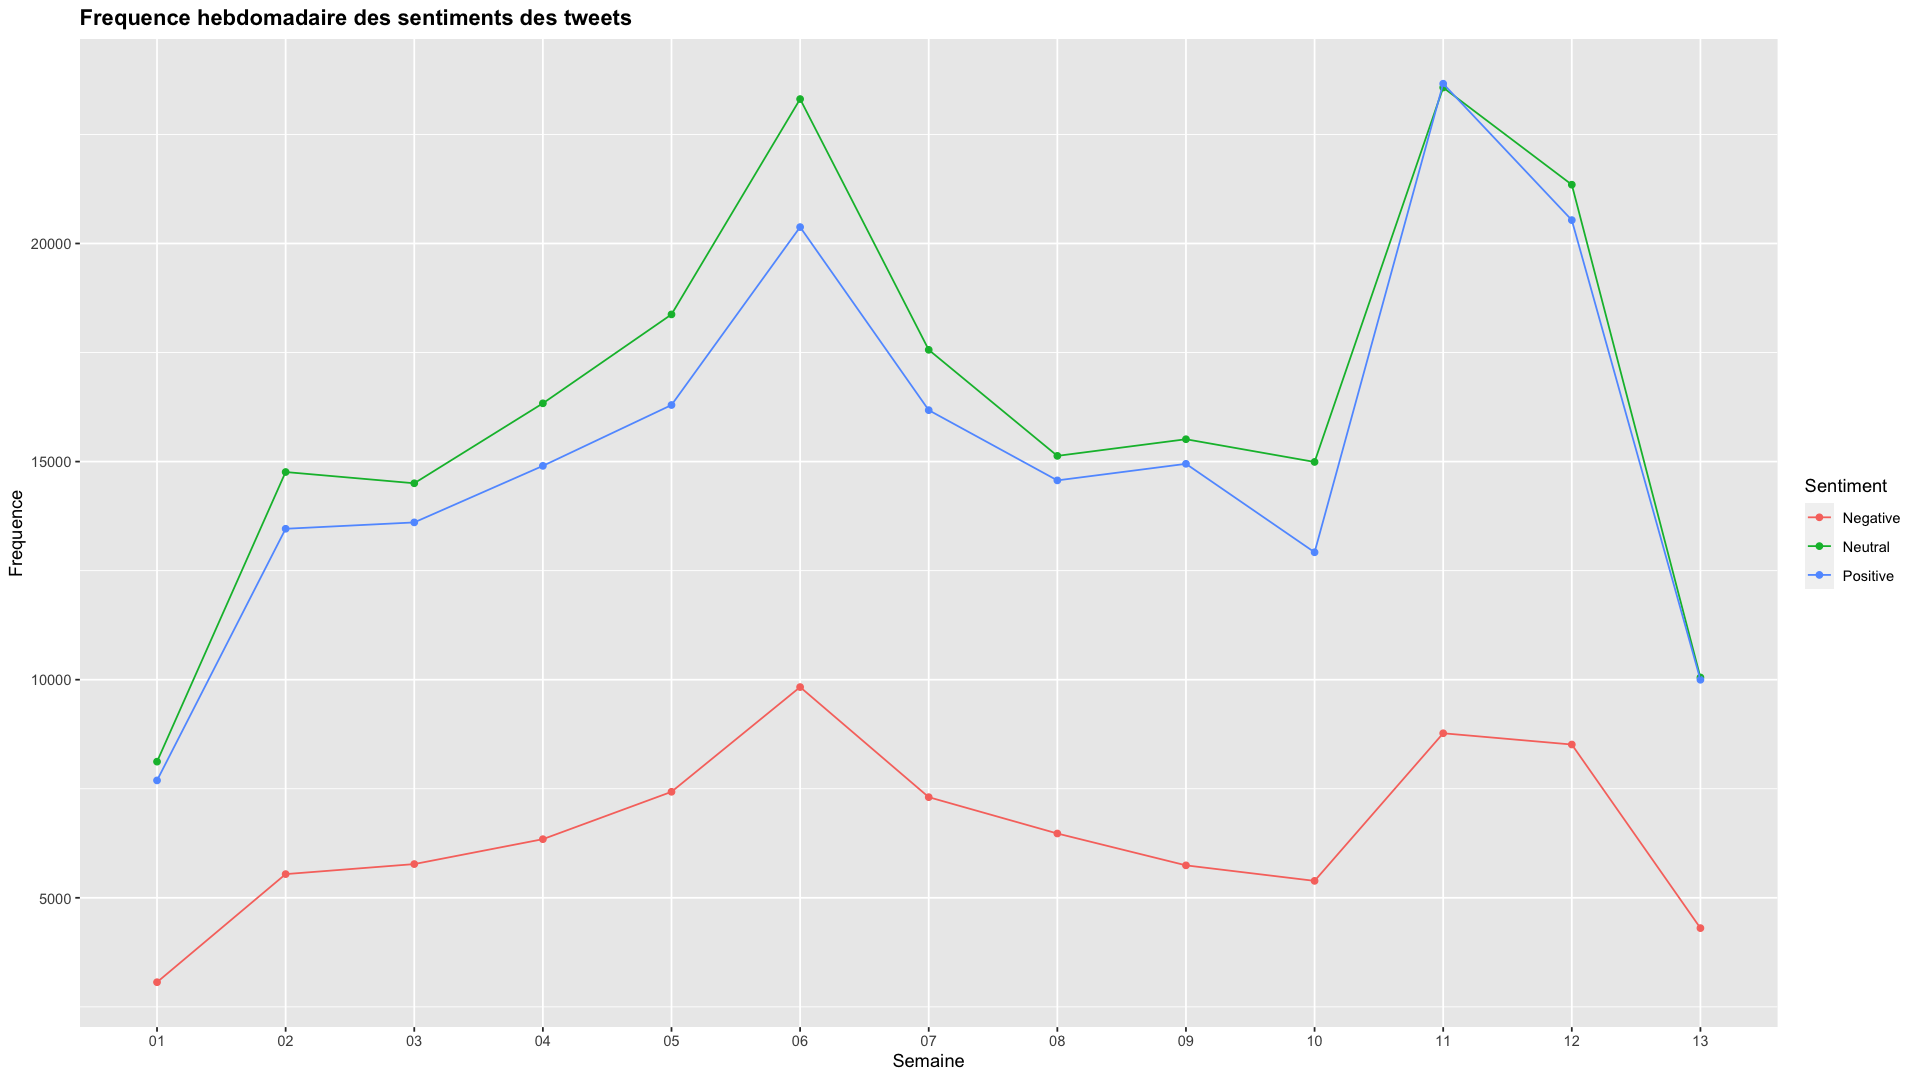

In [73]:
# graphique de l'évolution de la fréquence des sentiments par semaine
ggplot(polarity_sentiments, aes(x=Week,y=Freq, colour=Sentiment, group=Sentiment)) + 
    geom_point() + geom_line() + 
    labs(title="Frequence hebdomadaire des sentiments des tweets", x="Semaine", 
        y="Frequence") + theme(plot.title = element_text(face="bold"))

## Analyses de l'évolution des sentiments

In [74]:
# analyse des sentiments des tweets par semaine
# comme le temps de calcul est long, commençons par regarder les 3 premières semaines
for (x in week_numbers[1:3]){
    print(x)
    # extrait des mots des tweets par semaine
    tweets_words_week <- polarity(tweets_df[tweets_df$week == x,]$clean_content)$all %>%
        unnest_tokens(word, text.var) %>% 
        select(word)
    # on utilise les émotions du lexique nrc, en retirant les "positive" and "negative"
    tweets_words_nrc <- tweets_words_week %>% inner_join(nrc, by=c("word"="word"),
        relationship = "many-to-many") %>%
        filter(!sentiment %in% c("positive", "negative"))
    # décompte des émotions par semaine
    tweets_emotions_count <- tweets_words_nrc %>% 
        group_by(sentiment) %>%
        count(sentiment)

    print(tweets_emotions_count)
}

[1] "01"
# A tibble: 8 x 2
# Groups:   sentiment [8]
  sentiment        n
  <chr>        <int>
1 anger         3325
2 anticipation  8694
3 disgust       1988
4 fear          4673
5 joy           7137
6 sadness       3034
7 surprise      3235
8 trust        12059
[1] "02"
# A tibble: 8 x 2
# Groups:   sentiment [8]
  sentiment        n
  <chr>        <int>
1 anger         6202
2 anticipation 15891
3 disgust       3721
4 fear          8452
5 joy          12907
6 sadness       5884
7 surprise      6058
8 trust        21251
[1] "03"
# A tibble: 8 x 2
# Groups:   sentiment [8]
  sentiment        n
  <chr>        <int>
1 anger         6107
2 anticipation 15858
3 disgust       3559
4 fear          8358
5 joy          12787
6 sadness       5882
7 surprise      5958
8 trust        21668


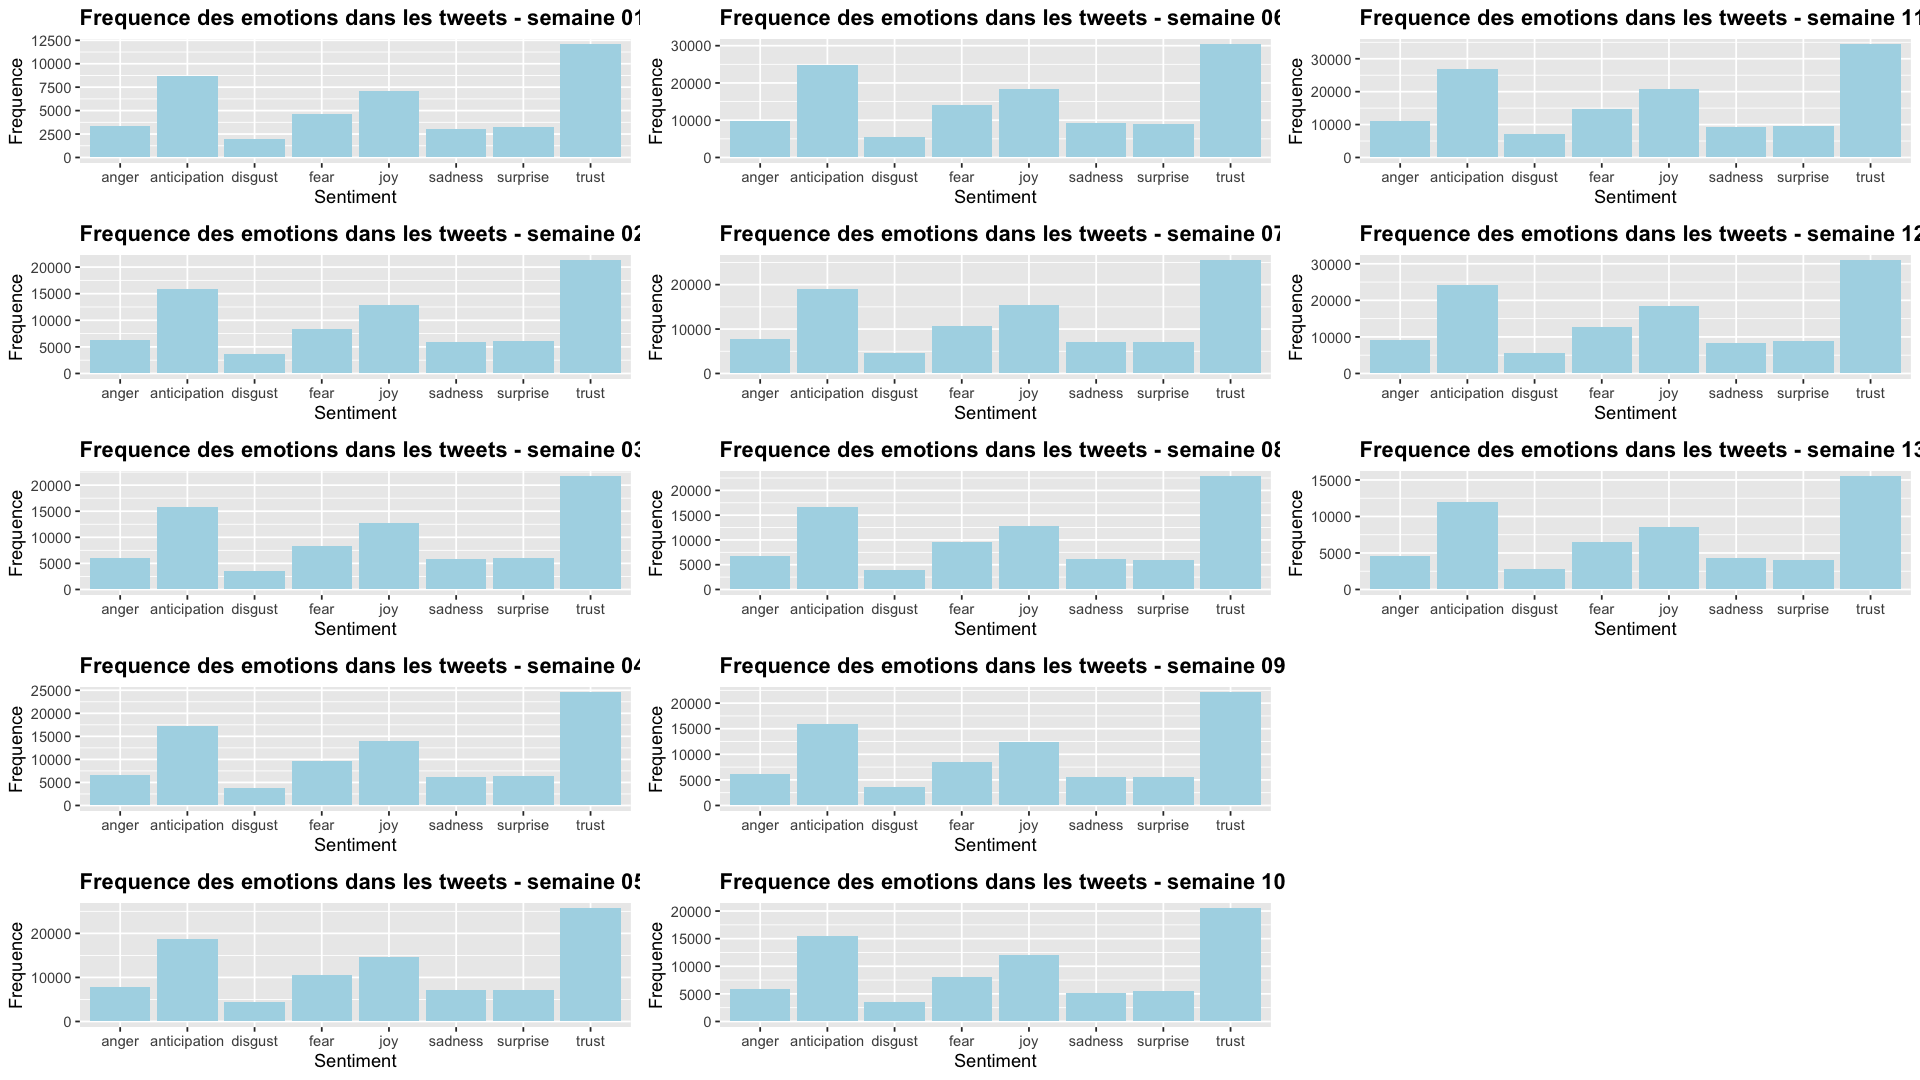

In [78]:
# analyse des sentiments des tweets par semaine
# on crée d'abord une variable qui contiendra la liste des graphiques hebdomadaires
weeklyPlots <- list()
for (x in week_numbers){
    # print(x)
    # extrait des mots des tweets par semaine
    tweets_words_week <- polarity(tweets_df[tweets_df$week == x,]$clean_content)$all %>%
        unnest_tokens(word, text.var) %>% select(word)
    # on utilise les émotions du lexique nrc, en retirant les "positive" and "negative"
    tweets_words_nrc <- tweets_words_week %>% inner_join(nrc, by=c("word"="word"), 
        relationship = "many-to-many") %>%
        filter(!sentiment %in% c("positive", "negative"))
    # décompte des émotions par semaine
    tweets_emotions_count <- tweets_words_nrc %>% 
        group_by(sentiment) %>%
        count(sentiment)

    # on crée la variable graphique, que l'on ajoute ensuite à la liste
    p1 <- ggplot(tweets_emotions_count, aes(x=sentiment, y=n)) + 
        geom_col(fill="lightblue") + 
        labs(title=paste("Frequence des emotions dans les tweets - semaine ", x, sep=""), 
            x="Sentiment", y="Frequence") + theme(plot.title = element_text(face="bold"))
    weeklyPlots[[x]] <- p1
}
# affichage de la liste des graphiques
multiplot(plotlist = weeklyPlots, cols =3)

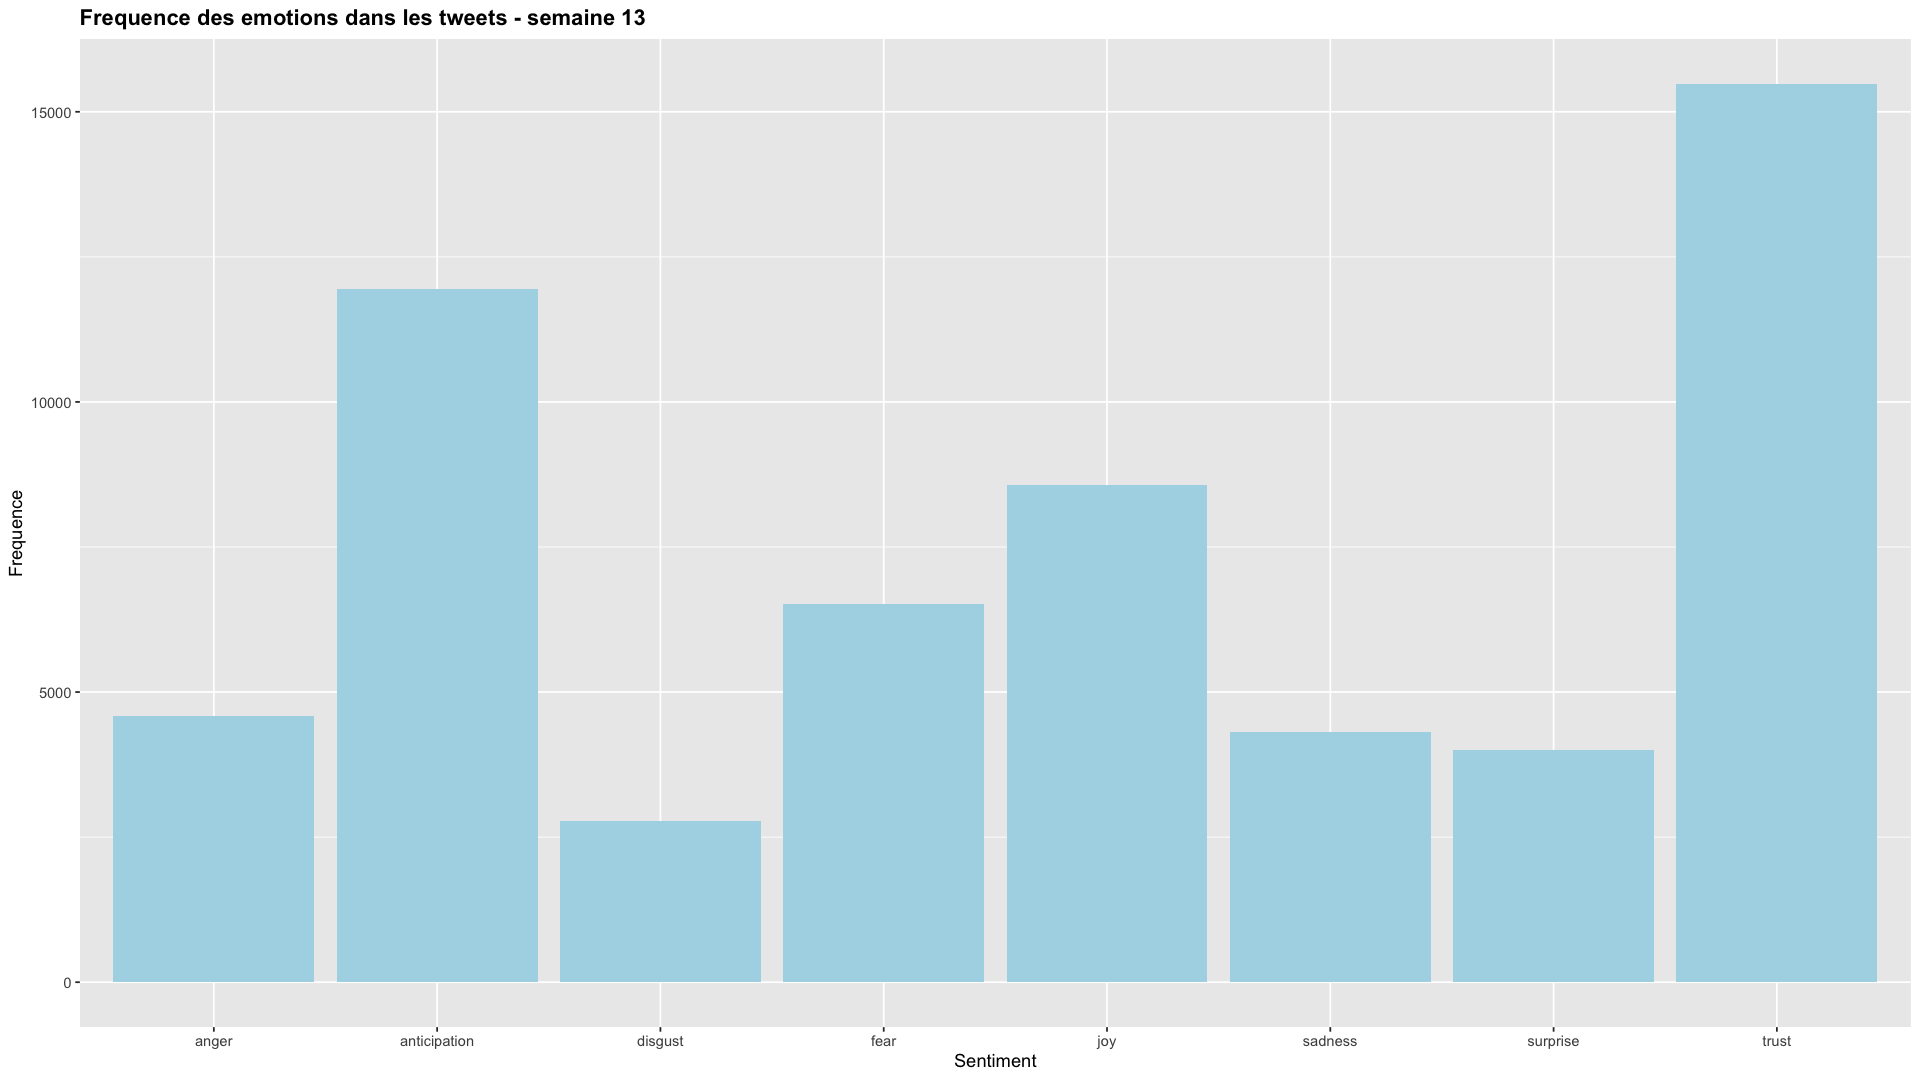

In [79]:
# on peut visualiser la dernière semaine avec un graphique plus grand
ggplot(tweets_emotions_count, aes(x=sentiment, y=n)) + geom_col(fill="lightblue") + 
    labs(title=paste("Frequence des emotions dans les tweets - semaine ", x, sep=""), 
        x="Sentiment", y="Frequence") + theme(plot.title = element_text(face="bold"))

In [80]:
# analyse des sentiments des tweets par semaine
# calcul des fréquences, pour pouvoir représenter l'évolution hebdo. des émotions
emotions_week_df <- data.frame()
for (x in week_numbers){
    # print(x)
    tweets_words_week <- polarity(tweets_df[tweets_df$week == x,]$clean_content)$all %>%
        unnest_tokens(word, text.var) %>%
        select(word)
    # retrait des étiquettes "positive" et "negative"
    tweets_words_nrc <- tweets_words_week %>% 
        inner_join(nrc, by=c("word"="word"), relationship = "many-to-many") %>%
        filter(!sentiment %in% c("positive", "negative"))

    # décompte des émotions par semaine
    tweets_emotions_count <- tweets_words_nrc %>% 
        group_by(sentiment) %>%
        count(sentiment)
    if(x == "01") 
        emotions_week_df <- tweets_emotions_count$n
    else 
        emotions_week_df <- rbind(emotions_week_df, tweets_emotions_count$n)
    
}
# création d'un dataframe contenant les fréquences des émotions par semaine
colnames(emotions_week_df) <- tweets_emotions_count$sentiment
rownames(emotions_week_df) <- week_numbers
emotions_week_df <- as.data.frame(emotions_week_df)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


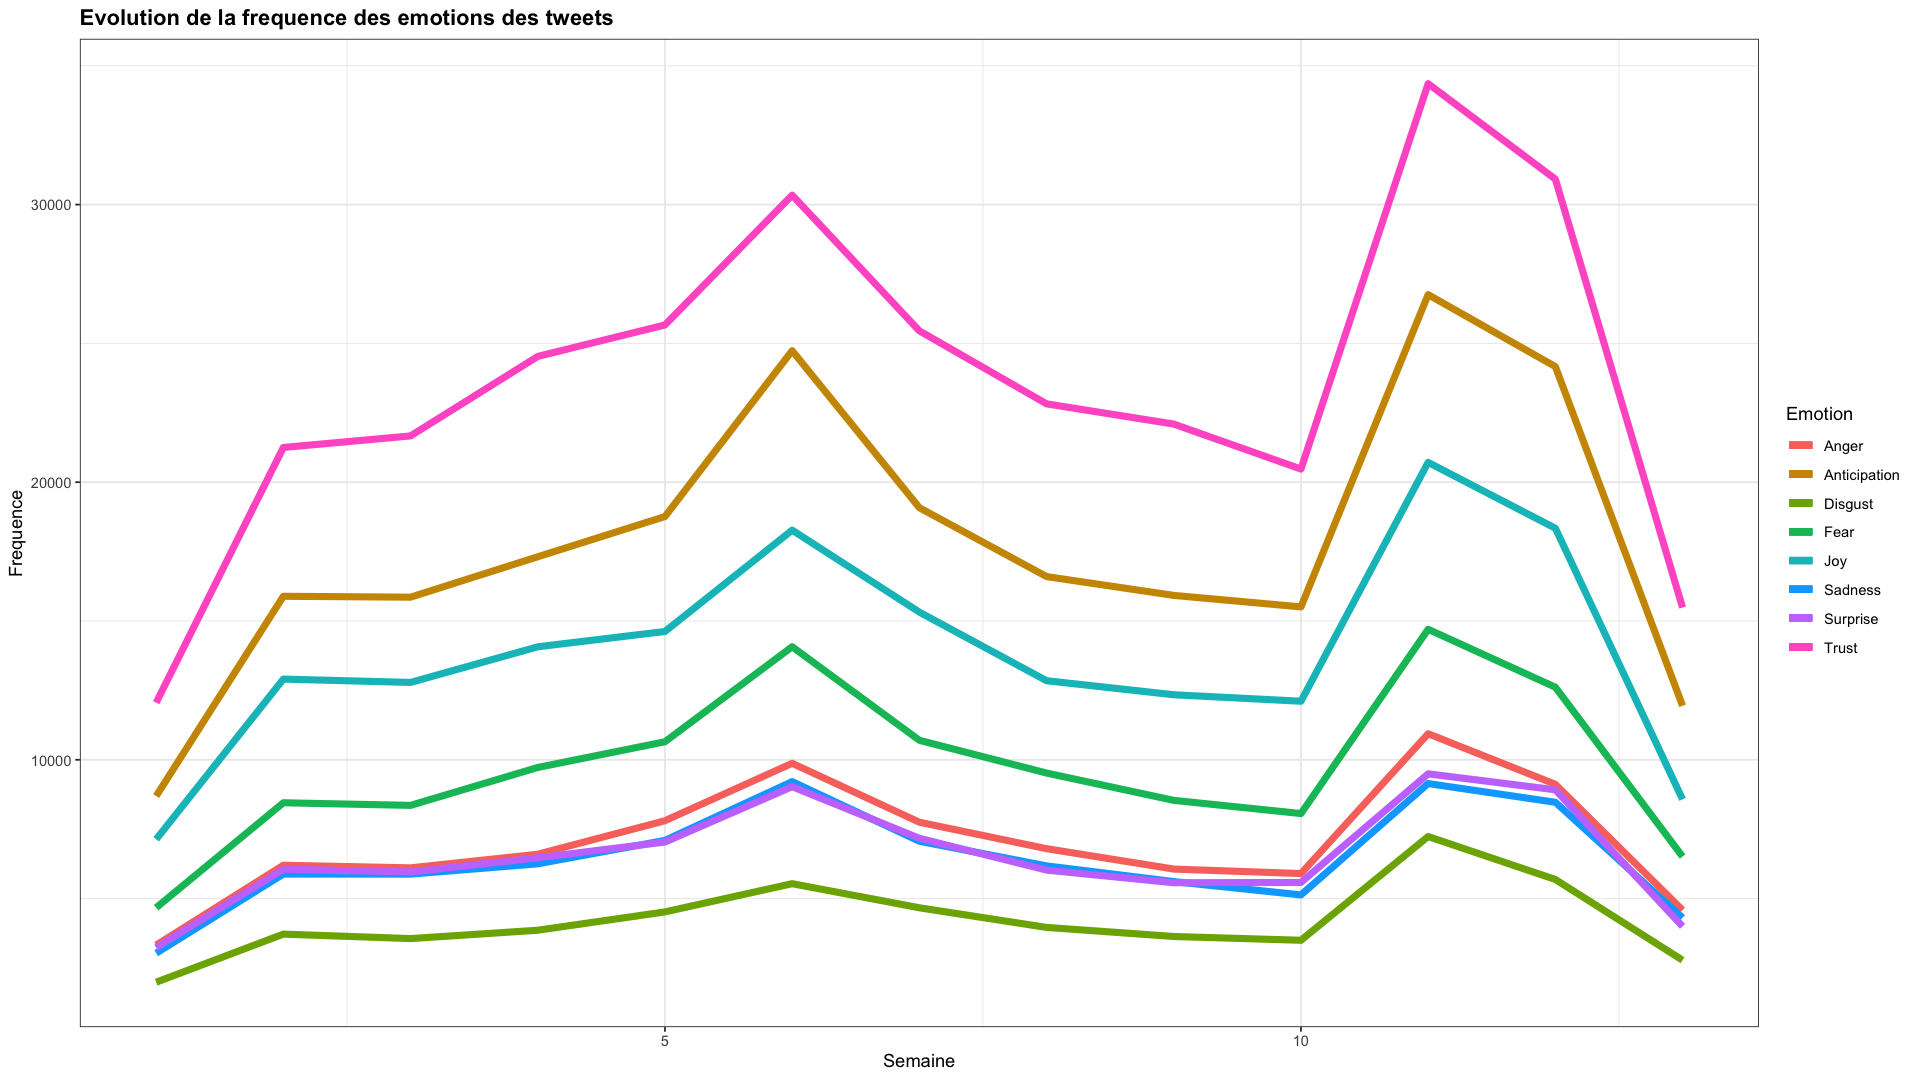

In [81]:
# graphique de l'évolution hebdomadaire des émotions à partir du dataframe précédent
ggplot(emotions_week_df, aes(x=1:nrow(emotions_week_df))) + 
    geom_line(aes( y=anger, colour="Anger"), size=2) + 
    geom_line(aes( y=anticipation, colour="Anticipation"), size=2) + 
    geom_line(aes( y=disgust, colour="Disgust"), size=2) + 
    geom_line(aes( y=fear, colour="Fear"), size=2) + 
    geom_line(aes( y=joy, colour="Joy"), size=2) + 
    geom_line(aes( y=sadness, colour="Sadness"), size=2) + 
    geom_line(aes( y=surprise, colour="Surprise"), size=2) + 
    geom_line(aes( y=trust, colour="Trust"), size=2) + 
    labs(title="Evolution de la frequence des emotions des tweets", x="Semaine", 
        y="Frequence", colour="Emotion") +
    theme_bw() + theme(plot.title = element_text(face="bold"))

In [82]:
# calcul de la proportion de chaque émotion par rapport au total des émotions par semaine
# permet de normaliser la mesure
emotions_prop_perweek <- as.data.frame(t(apply(emotions_week_df,1,function(x) x/sum(x))))
emotions_prop_perweek

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01,0.07531997,0.1969419,0.04503341,0.1058557,0.1616718,0.06872806,0.07328123,0.2731680
02,0.07717194,0.1977329,0.04630067,0.1051689,0.1606027,0.07321504,0.07538014,0.2644277
03,0.07616898,0.1977874,0.04438929,0.1042444,0.1594846,0.07336269,0.07431059,0.2702521
04,0.07428423,0.1949314,0.04346945,0.1094786,0.1584197,0.07040002,0.07283188,0.2761847
05,0.08117383,0.1951146,0.04701344,0.1107587,0.1520631,0.07380101,0.07318747,0.2668878
06,0.08154804,0.2042996,0.04573760,0.1162270,0.1509143,0.07609719,0.07459408,0.2505823
07,0.07974078,0.1962763,0.04802757,0.1100962,0.1575888,0.07267397,0.07378491,0.2618114
08,0.08020103,0.1958543,0.04674264,0.1123499,0.1515892,0.07289823,0.07110498,0.2692598
09,0.07600807,0.1995713,0.04556223,0.1070305,0.1547110,0.07035510,0.06982866,0.2769331


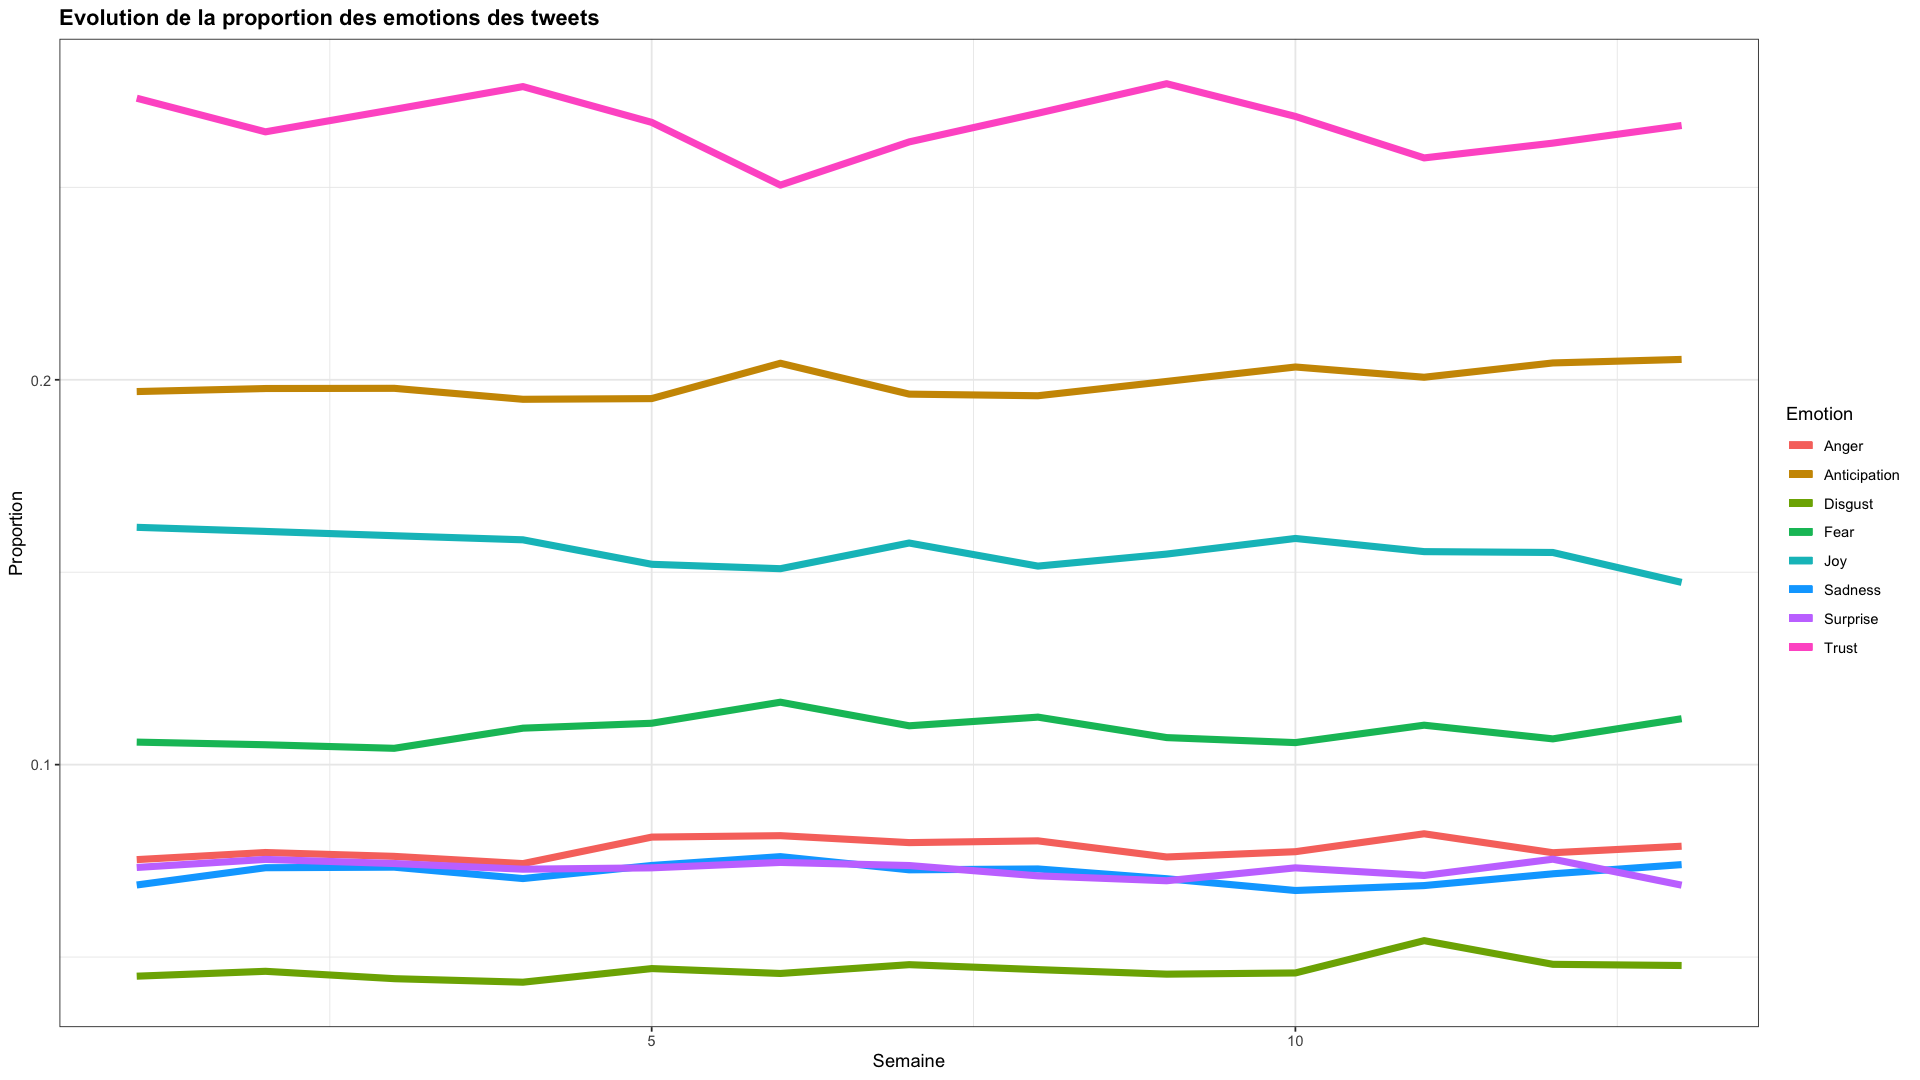

In [83]:
# graphique de l'évolution hebdomadaire des émotions à partir du dataframe précédent
ggplot(emotions_prop_perweek, aes(x=1:nrow(emotions_week_df))) + 
    geom_line(aes( y=anger, colour="Anger"), size=2) + 
    geom_line(aes( y=anticipation, colour="Anticipation"), size=2) + 
    geom_line(aes( y=disgust, colour="Disgust"), size=2) + 
    geom_line(aes( y=fear, colour="Fear"), size=2) + 
    geom_line(aes( y=joy, colour="Joy"), size=2) + 
    geom_line(aes( y=sadness, colour="Sadness"), size=2) + 
    geom_line(aes( y=surprise, colour="Surprise"), size=2) + 
    geom_line(aes( y=trust, colour="Trust"), size=2) + 
    labs(title="Evolution de la proportion des emotions des tweets", x="Semaine", 
        y="Proportion", colour="Emotion") +
    theme_bw() + theme(plot.title = element_text(face="bold"))

In [ ]:
# on voit que la proportion des émotions est relativement stable pendant les 13 semaines
# La confiance (trust) est l'émotion la plus prégnante, suivie de l'anticipation, 
# la joie et la peur. Les autres émotions suivent, avec le dégoût en dernière place.
# Il y a quelques semaines où on dénote des changements, des pics, mais globalement,
# c'est relativement constant.
